In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#install the NGBoost library
!pip install ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 3.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=6a2c4820c464e5def2580b26bf30870b5f9adfabd3a8d42948c8a5c3a5df2206
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


**Datset Preparation**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, StackingRegressor
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor

# Load dataset
df = pd.read_csv("processed_data_constant.csv")
output_cols = ['Yield', 'Surface Area', 'Porosity']
input_cols = [col for col in df.columns if col not in output_cols]
X = df[input_cols].values
Y = df[output_cols].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

**Models Training and Evaluation**


In [7]:
# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

# Define all 10 models
stack_base_models = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=4, random_state=42, verbosity=0))
]
stack_final_model = Ridge(alpha=1.0)
stack_model = StackingRegressor(estimators=stack_base_models, final_estimator=stack_final_model, passthrough=True)

models = {
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'GaussianProcess': MultiOutputRegressor(
        GaussianProcessRegressor(
            kernel=C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
            alpha=1e-2, normalize_y=True, random_state=42
        )
    ),
    'SVR': MultiOutputRegressor(SVR(kernel='rbf', C=1000.0, epsilon=0.01, gamma='auto')),
    'DNN': MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', max_iter=500, random_state=42)),
    'XGBoost': MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbosity=0)),
    'LightGBM': MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)),
    'HistGB': MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=100, random_state=42)),
    'QuantileNGBoost': MultiOutputRegressor(NGBRegressor(n_estimators=500, learning_rate=0.03, verbose=False, random_state=42)),
    'Stacking': MultiOutputRegressor(stack_model)
}
# Evaluate all models
all_results = {}
for name, model in models.items():
    print(f"\n===== Model: {name} =====")
    try:
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        results = {}
        for i, col in enumerate(output_cols):
            y_true = Y_test[:, i]
            y_pred = Y_pred[:, i]
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            r2 = r2_score(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)
            print(f"{col}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, MAPE={mape:.2f}%")
            results[col] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}
        all_results[name] = results
        joblib.dump(model, f"model_{name}.pkl")
    except Exception as e:
        print(f"{name} failed: {e}")
        all_results[name] = "Training failed"


===== Model: RandomForest =====
Yield: MAE=3.4490, RMSE=4.8339, R²=0.7942, MAPE=9.94%
Surface Area: MAE=230.6181, RMSE=396.8297, R²=0.7941, MAPE=377.31%
Porosity: MAE=0.1730, RMSE=0.2615, R²=0.9019, MAPE=416.71%

===== Model: GradientBoosting =====
Yield: MAE=2.5271, RMSE=3.2441, R²=0.9073, MAPE=7.86%
Surface Area: MAE=187.5459, RMSE=339.5999, R²=0.8492, MAPE=353.11%
Porosity: MAE=0.1690, RMSE=0.3011, R²=0.8699, MAPE=386.76%

===== Model: GaussianProcess =====
Yield: MAE=4.0720, RMSE=5.5381, R²=0.7298, MAPE=14.04%
Surface Area: MAE=164.3276, RMSE=249.4020, R²=0.9187, MAPE=382.66%
Porosity: MAE=0.1117, RMSE=0.1587, R²=0.9639, MAPE=147.85%

===== Model: SVR =====
Yield: MAE=5.0935, RMSE=6.4155, R²=0.6374, MAPE=16.15%
Surface Area: MAE=283.3742, RMSE=574.6715, R²=0.5682, MAPE=445.12%
Porosity: MAE=0.1902, RMSE=0.2618, R²=0.9016, MAPE=631.44%

===== Model: DNN =====


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Yield: MAE=4.1169, RMSE=5.6570, R²=0.7181, MAPE=12.98%
Surface Area: MAE=222.1586, RMSE=313.2075, R²=0.8717, MAPE=259.70%
Porosity: MAE=0.1716, RMSE=0.2648, R²=0.8994, MAPE=771.80%

===== Model: XGBoost =====
Yield: MAE=2.9453, RMSE=4.4668, R²=0.8242, MAPE=9.01%
Surface Area: MAE=134.3377, RMSE=234.2663, R²=0.9282, MAPE=199.18%
Porosity: MAE=0.1404, RMSE=0.2793, R²=0.8881, MAPE=212.85%

===== Model: LightGBM =====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 7
[LightGBM] [Info] Start training from score 39.407429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Yield: MAE=5.0544, RMSE=6.6437, R²=0.6112, MAPE=16.66%
Surface Area: MAE=393.2172, RMSE=653.0889, R²=0.4423, MAPE=1716.88%
Porosity: MAE=0.3098, RMSE=0.4614, R²=0.6945, MAPE=1131.03%

===== Model: QuantileNGBoost =====
Yield: MAE=2.4175, RMSE=2.8853, R²=0.9267, MAPE=7.67%
Surface Area: MAE=179.8259, RMSE=310.1467, R²=0.8742, MAPE=313.94%
Porosity: MAE=0.1559, RMSE=0.2870, R²=0.8818, MAPE=249.78%

===== Model: Stacking =====
Yield: MAE=5.6685, RMSE=6.8896, R²=0.5818, MAPE=15.82%
Surface Area: MAE=192.2023, RMSE=324.2905, R²=0.8625, MAPE=903.53%
Porosity: MAE=0.2054, RMSE=0.3110, R²=0.8612, MAPE=397.30%


In [8]:

# Print summary for all models
print("\n===== Summary of All Models =====")
for model_name, metrics in all_results.items():
    print(f"\nModel: {model_name}")
    if isinstance(metrics, dict):
        for target, scores in metrics.items():
            print(f"{target:<15} - MAE: {scores['MAE']:.4f}, RMSE: {scores['RMSE']:.4f}, "
                  f"R²: {scores['R2']:.4f}, MAPE: {scores['MAPE']:.2f}%")
    else:
        print("Training failed")


===== Summary of All Models =====

Model: RandomForest
Yield           - MAE: 3.4490, RMSE: 4.8339, R²: 0.7942, MAPE: 9.94%
Surface Area    - MAE: 230.6181, RMSE: 396.8297, R²: 0.7941, MAPE: 377.31%
Porosity        - MAE: 0.1730, RMSE: 0.2615, R²: 0.9019, MAPE: 416.71%

Model: GradientBoosting
Yield           - MAE: 2.5271, RMSE: 3.2441, R²: 0.9073, MAPE: 7.86%
Surface Area    - MAE: 187.5459, RMSE: 339.5999, R²: 0.8492, MAPE: 353.11%
Porosity        - MAE: 0.1690, RMSE: 0.3011, R²: 0.8699, MAPE: 386.76%

Model: GaussianProcess
Yield           - MAE: 4.0720, RMSE: 5.5381, R²: 0.7298, MAPE: 14.04%
Surface Area    - MAE: 164.3276, RMSE: 249.4020, R²: 0.9187, MAPE: 382.66%
Porosity        - MAE: 0.1117, RMSE: 0.1587, R²: 0.9639, MAPE: 147.85%

Model: SVR
Yield           - MAE: 5.0935, RMSE: 6.4155, R²: 0.6374, MAPE: 16.15%
Surface Area    - MAE: 283.3742, RMSE: 574.6715, R²: 0.5682, MAPE: 445.12%
Porosity        - MAE: 0.1902, RMSE: 0.2618, R²: 0.9016, MAPE: 631.44%

Model: DNN
Yield    

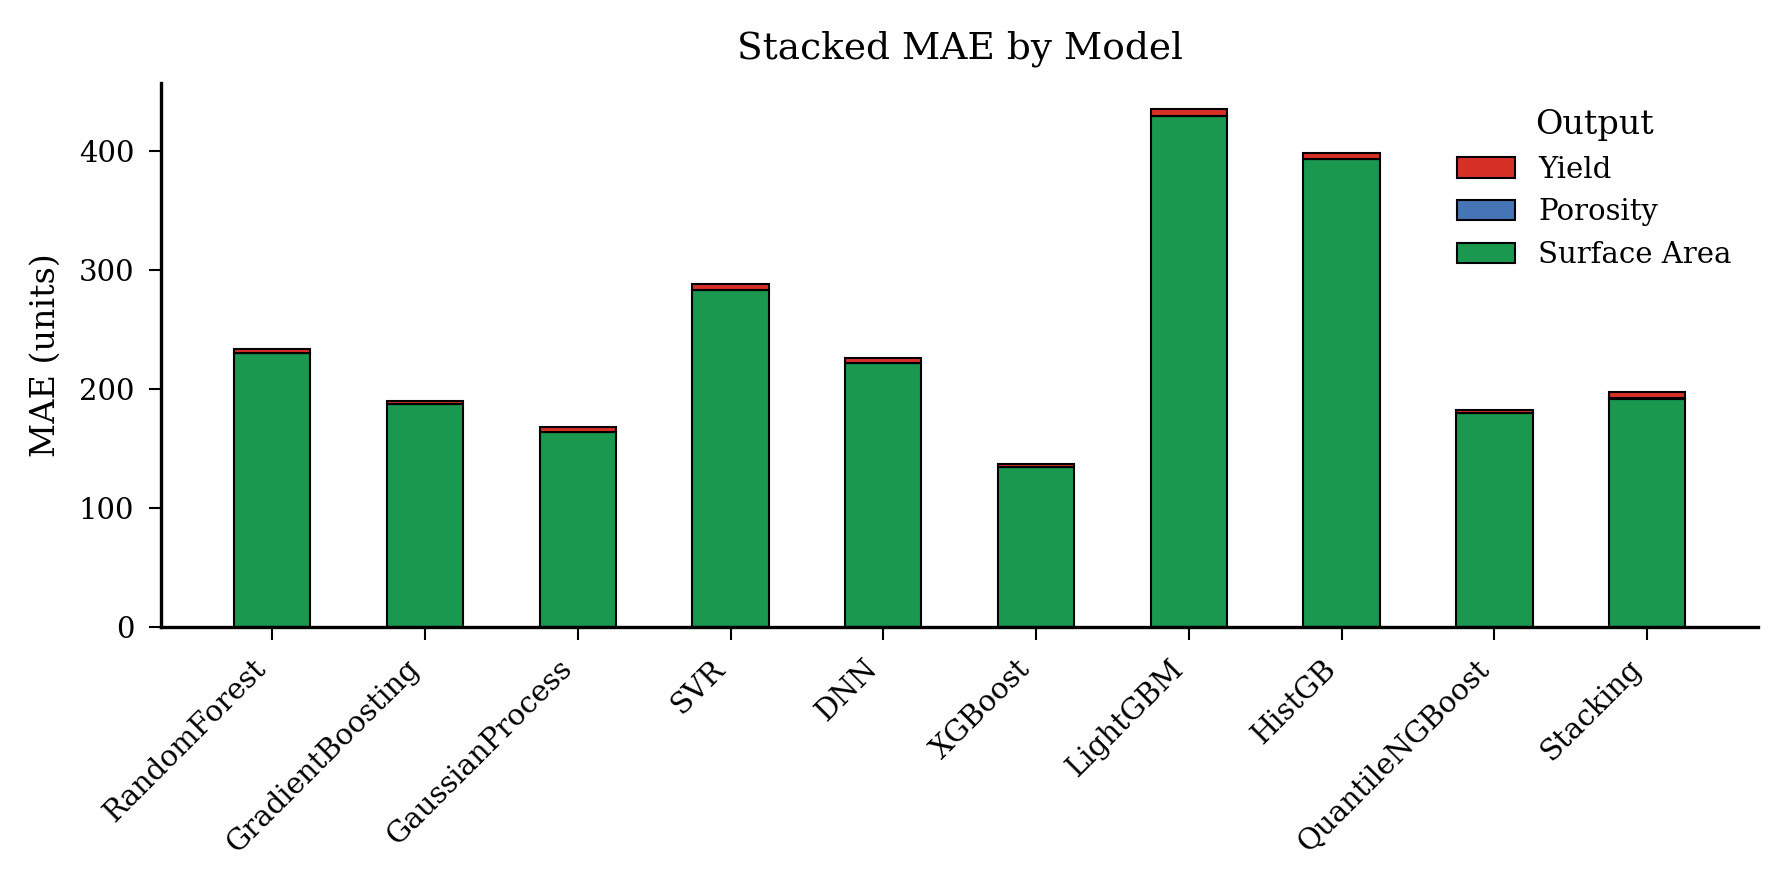

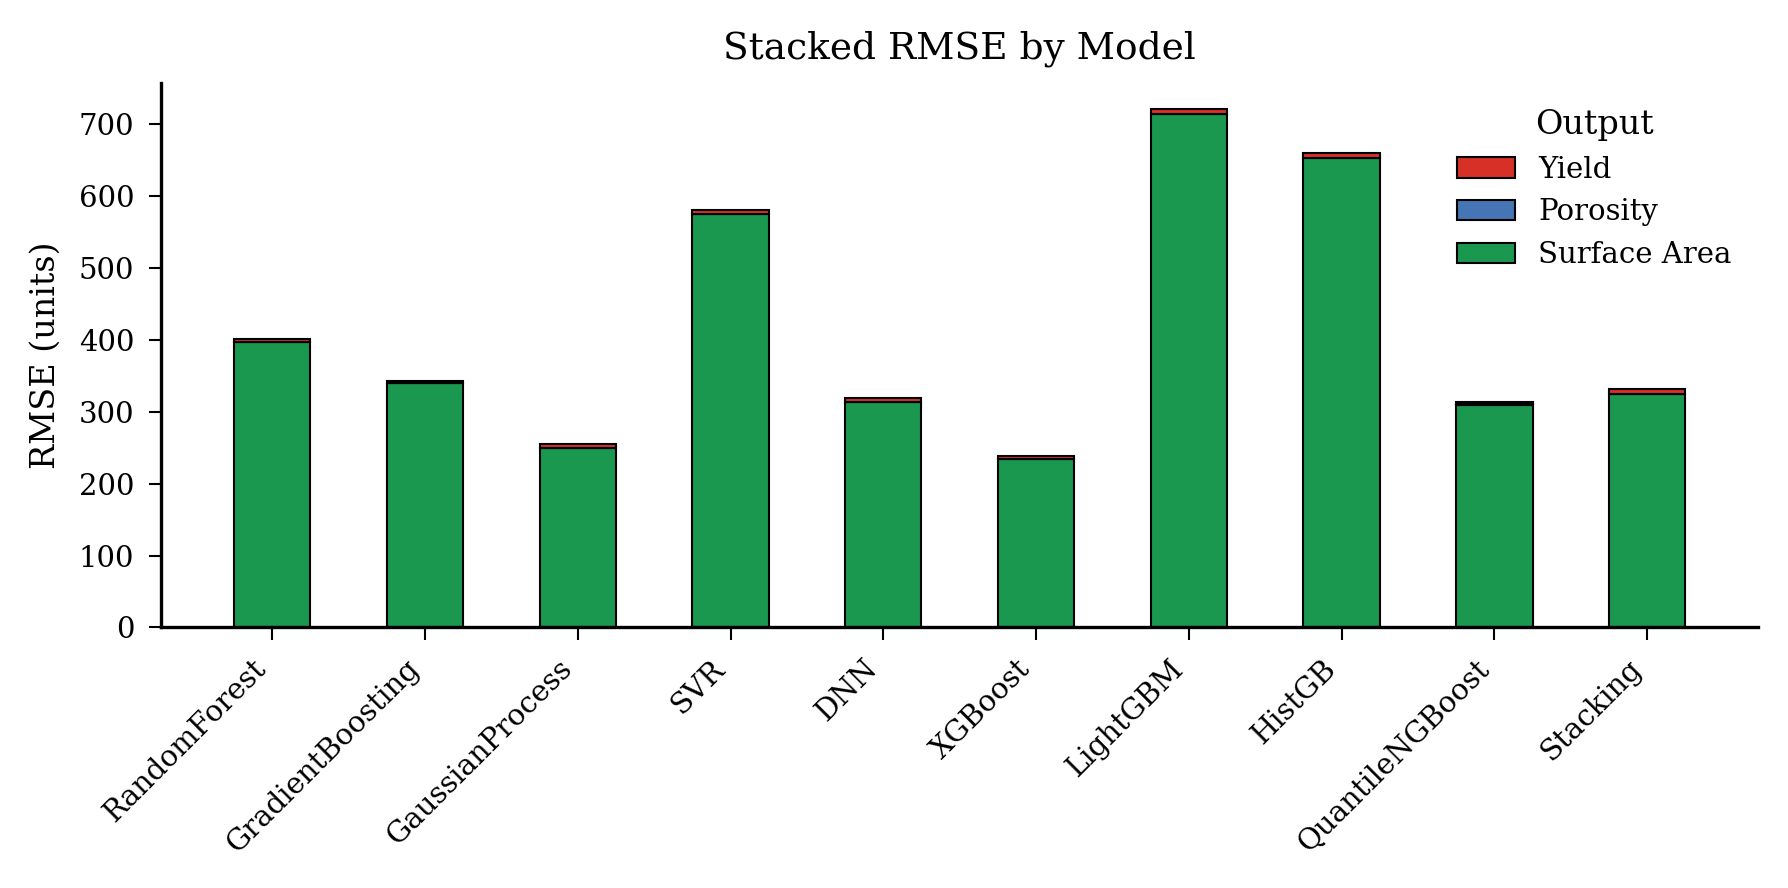

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Nature-style font and formatting
mpl.rcParams.update({
    'font.family': 'serif',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'figure.dpi': 300
})

# Model order
model_names = [
    'RandomForest', 'GradientBoosting', 'GaussianProcess', 'SVR', 'DNN',
    'XGBoost', 'LightGBM', 'HistGB', 'QuantileNGBoost', 'Stacking'
]

# Outputs and their colors
# Order: Surface Area → Porosity → Yield (so Yield appears on top)
outputs = ['Surface Area', 'Porosity', 'Yield']
output_colors = {
    'Yield': '#d73027',
    'Surface Area': '#1a9850',
    'Porosity': '#4575b4'
}

# Metric types
metrics = ['MAE', 'RMSE']

# Loop for MAE and RMSE
for metric in metrics:
    metric_values = {output: [] for output in outputs}

    for model in model_names:
        result = all_results.get(model)
        for output in outputs:
            if isinstance(result, dict) and output in result:
                metric_values[output].append(result[output][metric])
            else:
                metric_values[output].append(np.nan)

    # X positions
    x = np.arange(len(model_names))
    bar_width = 0.5
    bottom = np.zeros(len(model_names))

    fig, ax = plt.subplots(figsize=(6, 3))

    for output in outputs:
        ax.bar(x, metric_values[output], bottom=bottom, label=output,
               color=output_colors[output], width=bar_width, edgecolor='black', linewidth=0.5)
        bottom += np.array(metric_values[output])

    # Aesthetic formatting
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylabel(f"{metric} (units)", fontsize=8)
    ax.set_title(f"Stacked {metric} by Model", fontsize=9, pad=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='both', direction='out', length=3, width=0.5)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title="Output", frameon=False, loc='upper right')


    plt.tight_layout()
    plt.savefig(f"stacked_{metric.lower()}_nature_style.pdf", bbox_inches='tight')
    plt.show()


<ipython-input-10-aca02ec888eb>:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


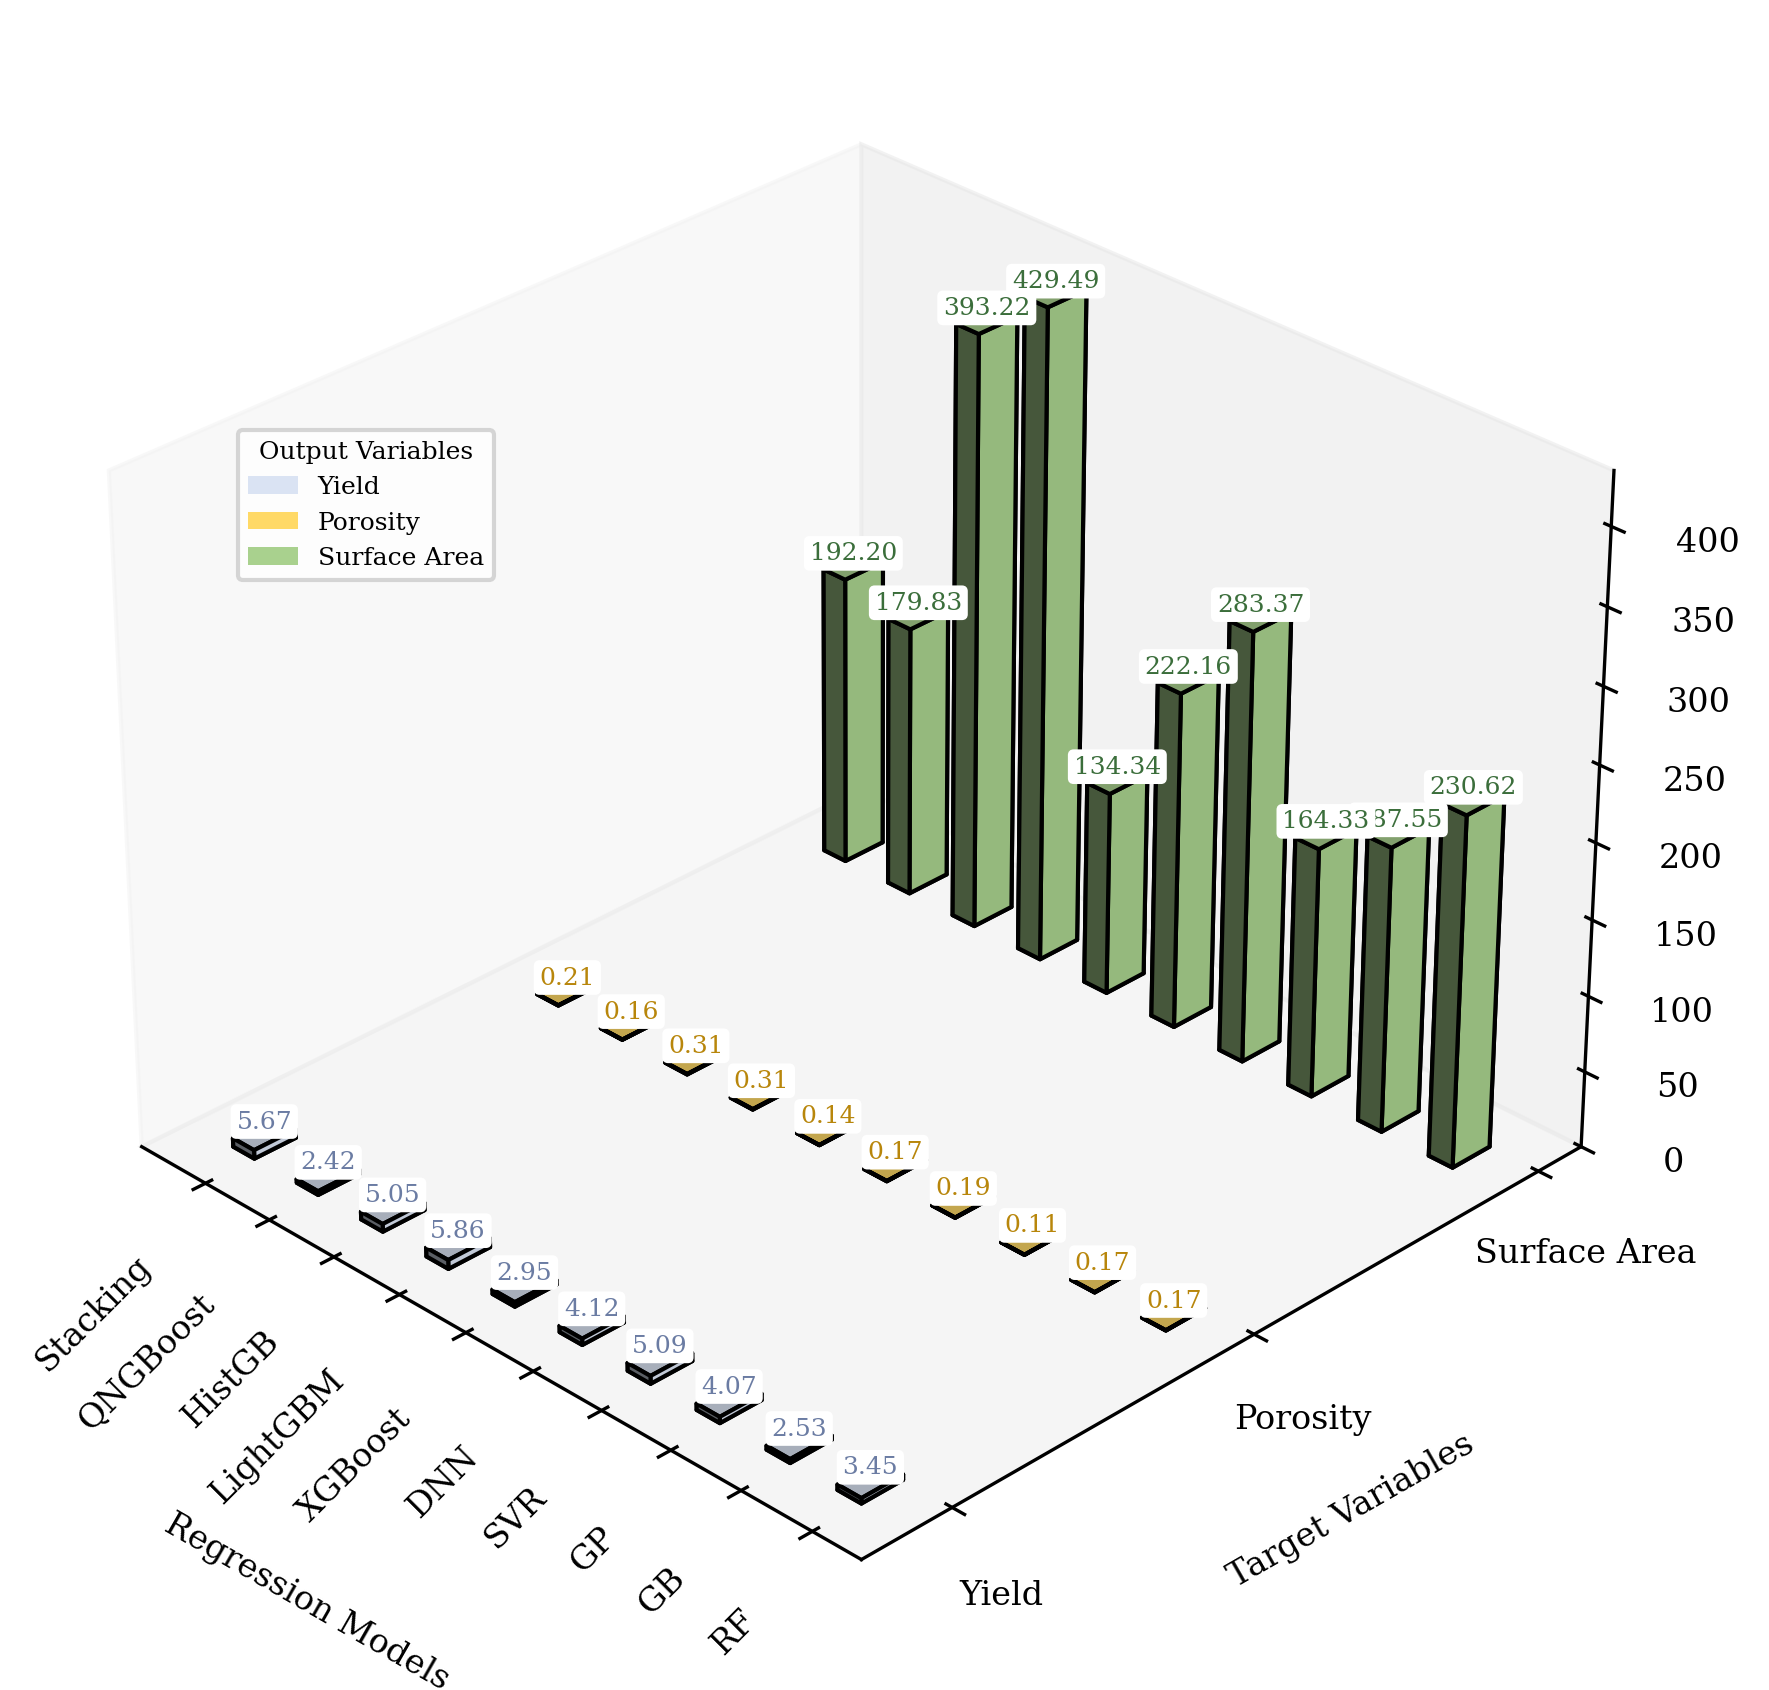

<ipython-input-10-aca02ec888eb>:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


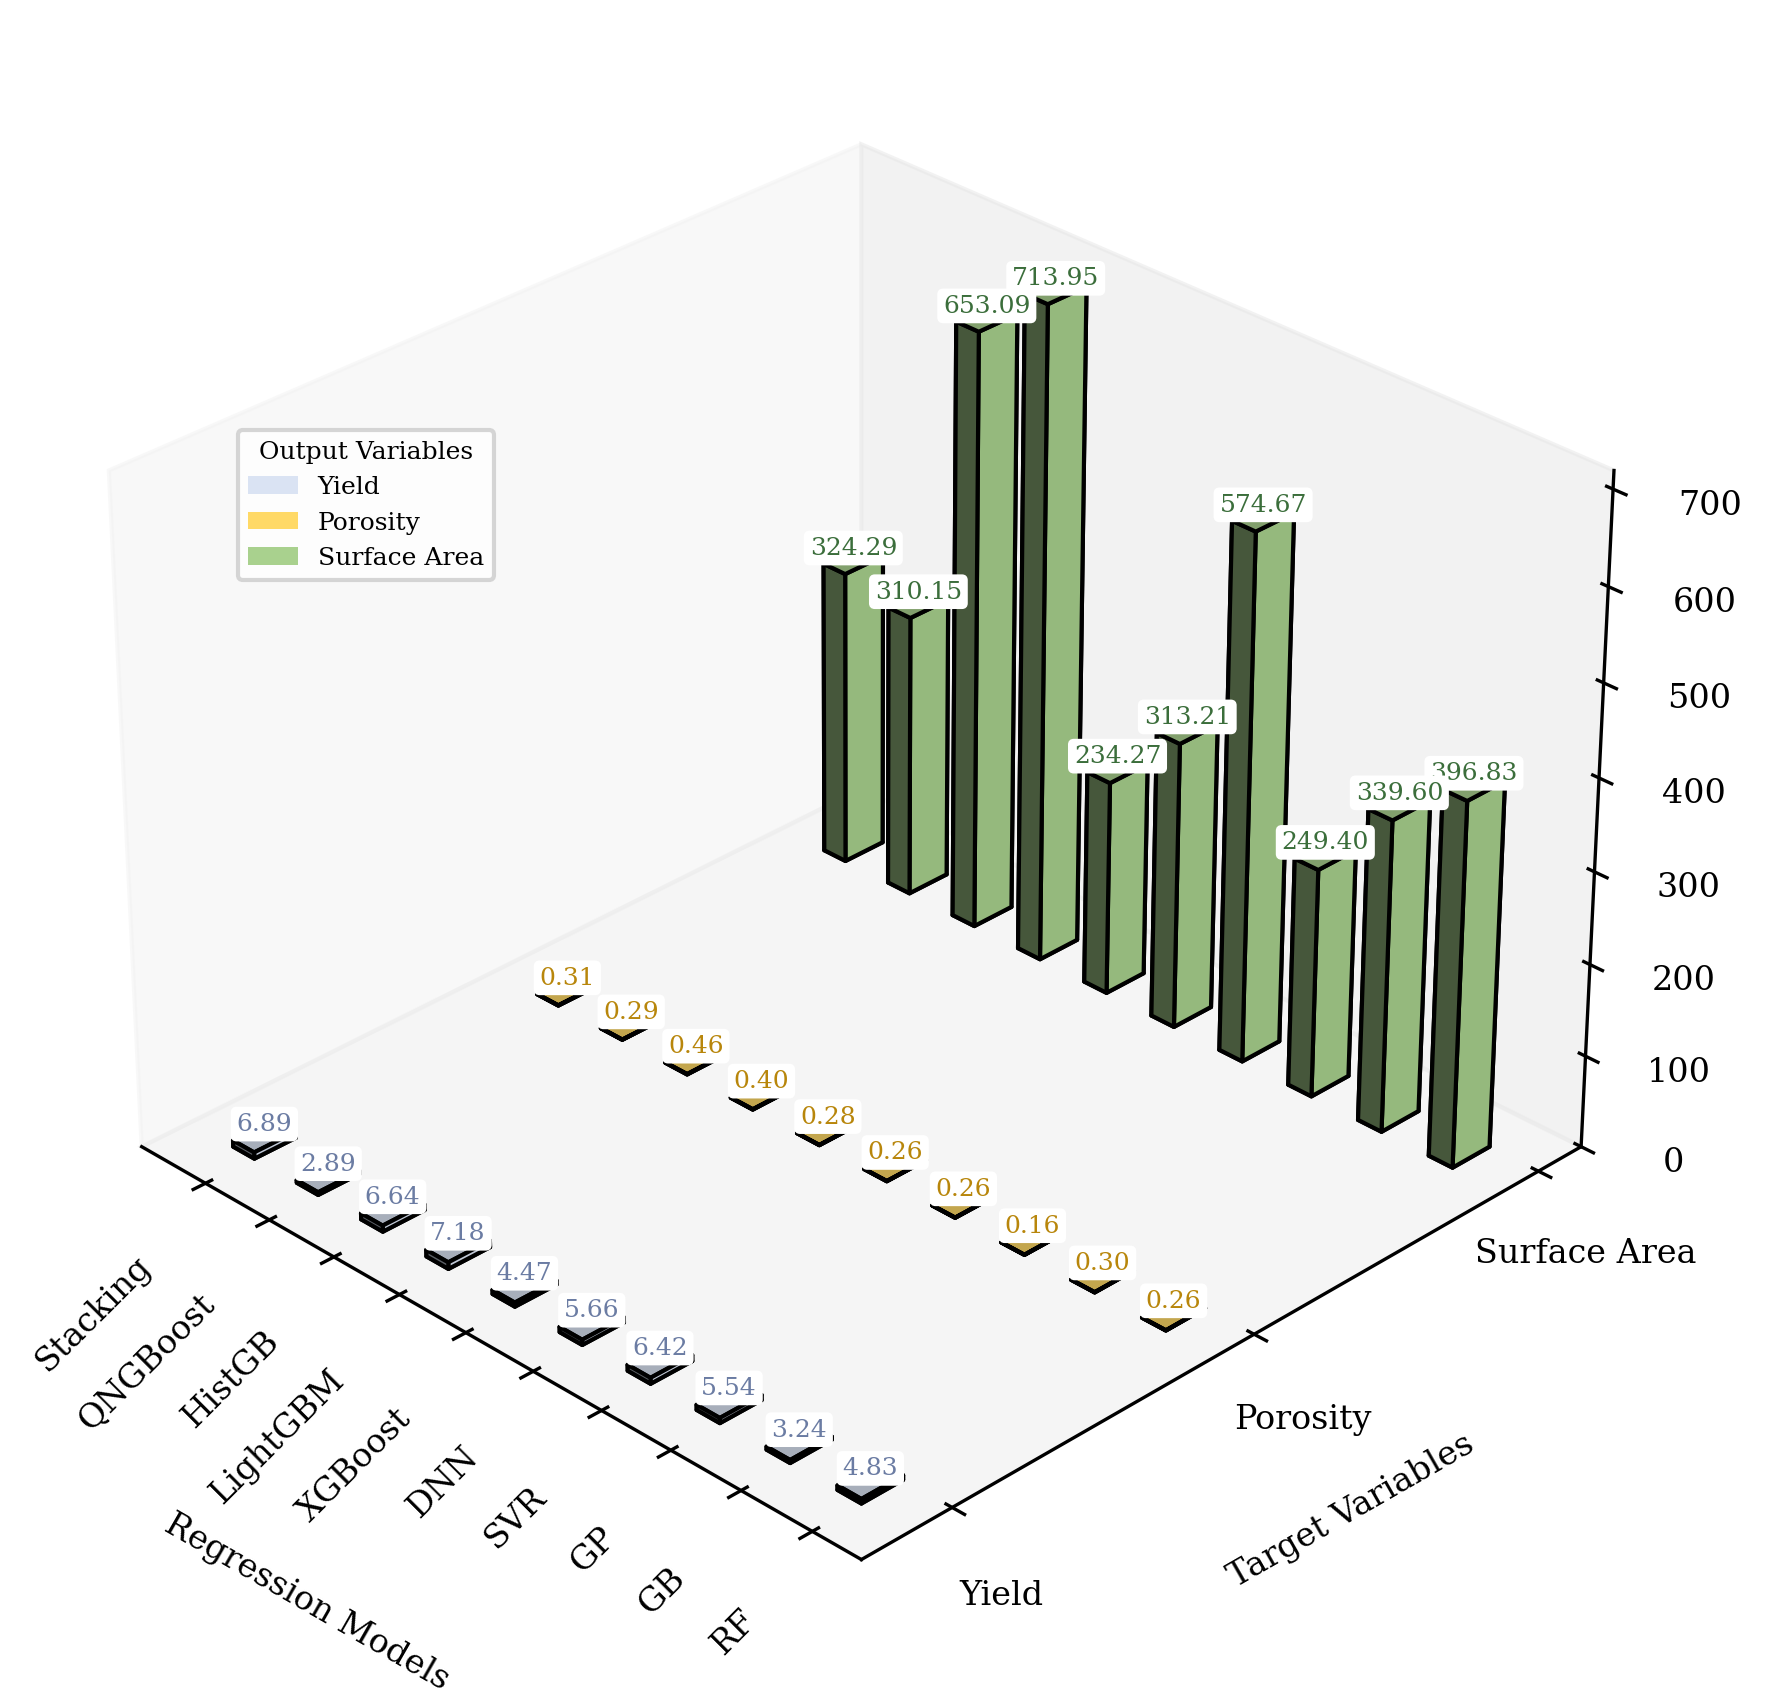

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rcParams
from matplotlib.patches import Patch

# Nature-style font settings
rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.dpi": 300
})

label_map = {
    'RandomForest': 'RF',
    'GradientBoosting': 'GB',
    'GaussianProcess': 'GP',
    'SVR': 'SVR',
    'DNN': 'DNN',
    'XGBoost': 'XGBoost',
    'LightGBM': 'LightGBM',
    'HistGB': 'HistGB',
    'QuantileNGBoost': 'QNGBoost',
    'Stacking': 'Stacking'
}

# Models and outputs
model_names = [
    'RandomForest', 'GradientBoosting', 'GaussianProcess', 'SVR', 'DNN',
    'XGBoost', 'LightGBM', 'HistGB', 'QuantileNGBoost', 'Stacking'
]

# Output order: Surface Area → Porosity → Yield (bottom to top)
outputs = ['Surface Area', 'Porosity', 'Yield']

# Bar fill colors (light tones)
colors = {
    'Yield': '#DAE3F3',
    'Porosity': '#FFD966',
    'Surface Area': '#A9D18E'
}

# Annotation text colors (darker tones)
text_colors = {
    'Yield': '#6B7CA3',
    'Porosity': '#B8860B',
    'Surface Area': '#3B6E3B'
}

# Metrics to plot
metrics = ['MAE', 'RMSE']

for metric in metrics:
    # Flattened values [Surface → Porosity → Yield]
    z_values = np.array([
        all_results[model][output][metric]
        for output in outputs
        for model in model_names
    ])

    # 3D bar positions
    _y = np.array([0, 6, 12])  # Surface → Porosity → Yield
    _x = np.arange(len(model_names)) * 3
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    dz = z_values
    z = np.zeros_like(dz)
    dx, dy = 1, 0.8

    # Bar and annotation label assignments
    bar_colors = [colors[outputs[j]] for j in np.repeat(np.arange(len(outputs)), len(model_names))]
    bar_labels = np.repeat(outputs, len(model_names))

    # Create figure
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Draw 3D bars
    ax.bar3d(x, y, z, dx, dy, dz, color=bar_colors, edgecolor='black', shade=True)

    # Add title for each figure
    #ax.set_title(f"3D Comparison of {metric}", pad=20)

    # Axes formatting
    ax.set_xlabel("Regression Models", labelpad=27)
    ax.set_ylabel("Target Variables", labelpad=10)
    ax.set_zlabel(f"{metric}", labelpad=12)
    ax.set_zlim(0, np.nanmax(dz) + 5)

    ax.set_xticks(_x)
    ax.set_xticklabels([label_map[m] for m in model_names], rotation=45, ha='right', fontsize=8)
    ax.set_yticks(_y)
    ax.set_yticklabels(outputs, fontsize=8)
    ax.tick_params(axis='both', which='major', pad=5)

    # Add annotations
    for i in range(len(dz)):
        output_name = bar_labels[i]
        ax.text(
            x[i] + dx / 2, y[i] + dy / 2, dz[i] + 0.5,
            f"{dz[i]:.2f}",
            ha='center', va='bottom',
            fontsize=6,
            color=text_colors[output_name],
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.15')
        )

    # 3D view
    ax.view_init(elev=30, azim=135)
    ax.grid(False)

    # Legend
    legend_elements = [Patch(facecolor=colors[o], label=o) for o in outputs[::-1]]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.12, 0.76),
              title='Output Variables', fontsize=6, title_fontsize=6)

    # Save
    plt.tight_layout()
    plt.savefig(f"{metric.lower()}_3d_model_comparison.pdf", bbox_inches='tight')
    plt.savefig(f"{metric.lower()}_3d_model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()


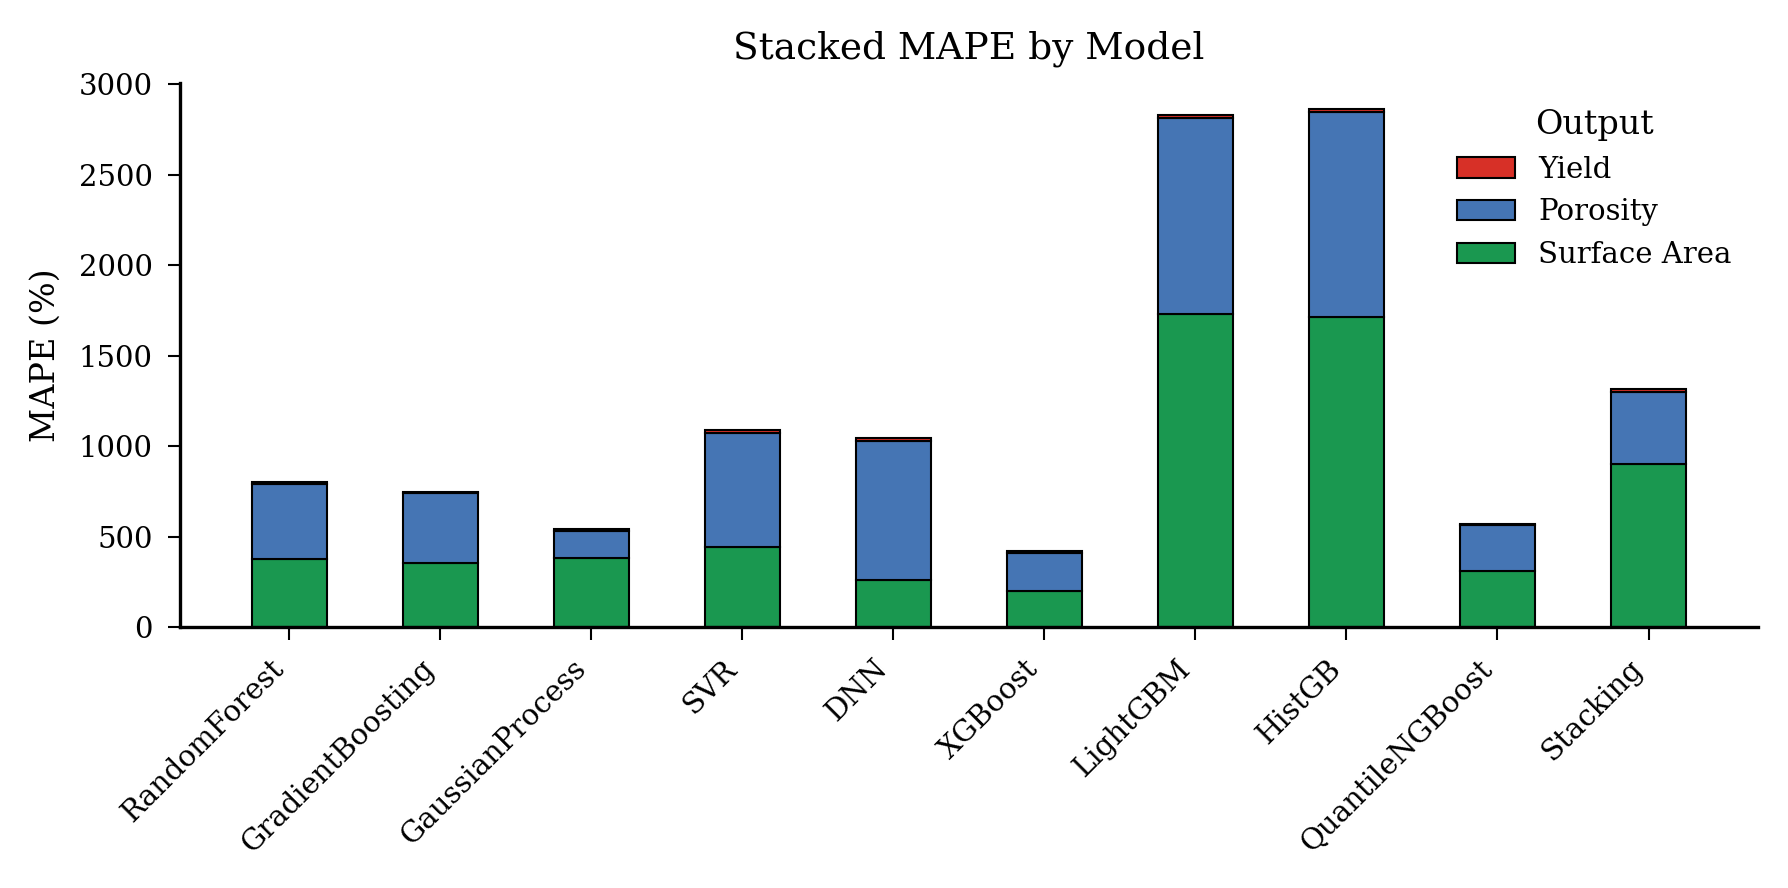

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Use Nature-style serif font
mpl.rcParams.update({
    'font.family': 'serif',
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'figure.dpi': 300
})

# Correct output order: Surface Area → Porosity → Yield
outputs = ['Surface Area', 'Porosity', 'Yield']
output_colors = {
    'Yield': '#d73027',         # red (top)
    'Surface Area': '#1a9850',  # green (bottom)
    'Porosity': '#4575b4'       # blue (middle)
}

model_names = list(all_results.keys())
mape_values = {output: [] for output in outputs}

# Extract MAPE values
for model in model_names:
    result = all_results.get(model)
    for output in outputs:
        if isinstance(result, dict) and output in result:
            mape_values[output].append(result[output]['MAPE'])
        else:
            mape_values[output].append(np.nan)

# Bar positions
x = np.arange(len(model_names))
bar_width = 0.5
bottom = np.zeros(len(model_names))

# Create figure
fig, ax = plt.subplots(figsize=(6, 3))

# Plot stacked bars
for output in outputs:
    ax.bar(x, mape_values[output], bottom=bottom, label=output,
           color=output_colors[output], width=bar_width, edgecolor='black', linewidth=0.5)
    bottom += np.array(mape_values[output])

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylabel("MAPE (%)", fontsize=8)
ax.set_title("Stacked MAPE by Model", fontsize=9, pad=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.tick_params(axis='both', direction='out', length=3, width=0.5)

# Reverse legend order to match top-down stack
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Output", frameon=False, loc='upper right')

# Save and show
plt.tight_layout()
plt.savefig("stacked_mape_nature_style.pdf", bbox_inches='tight')
plt.show()


<ipython-input-12-42b94899e744>:110: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


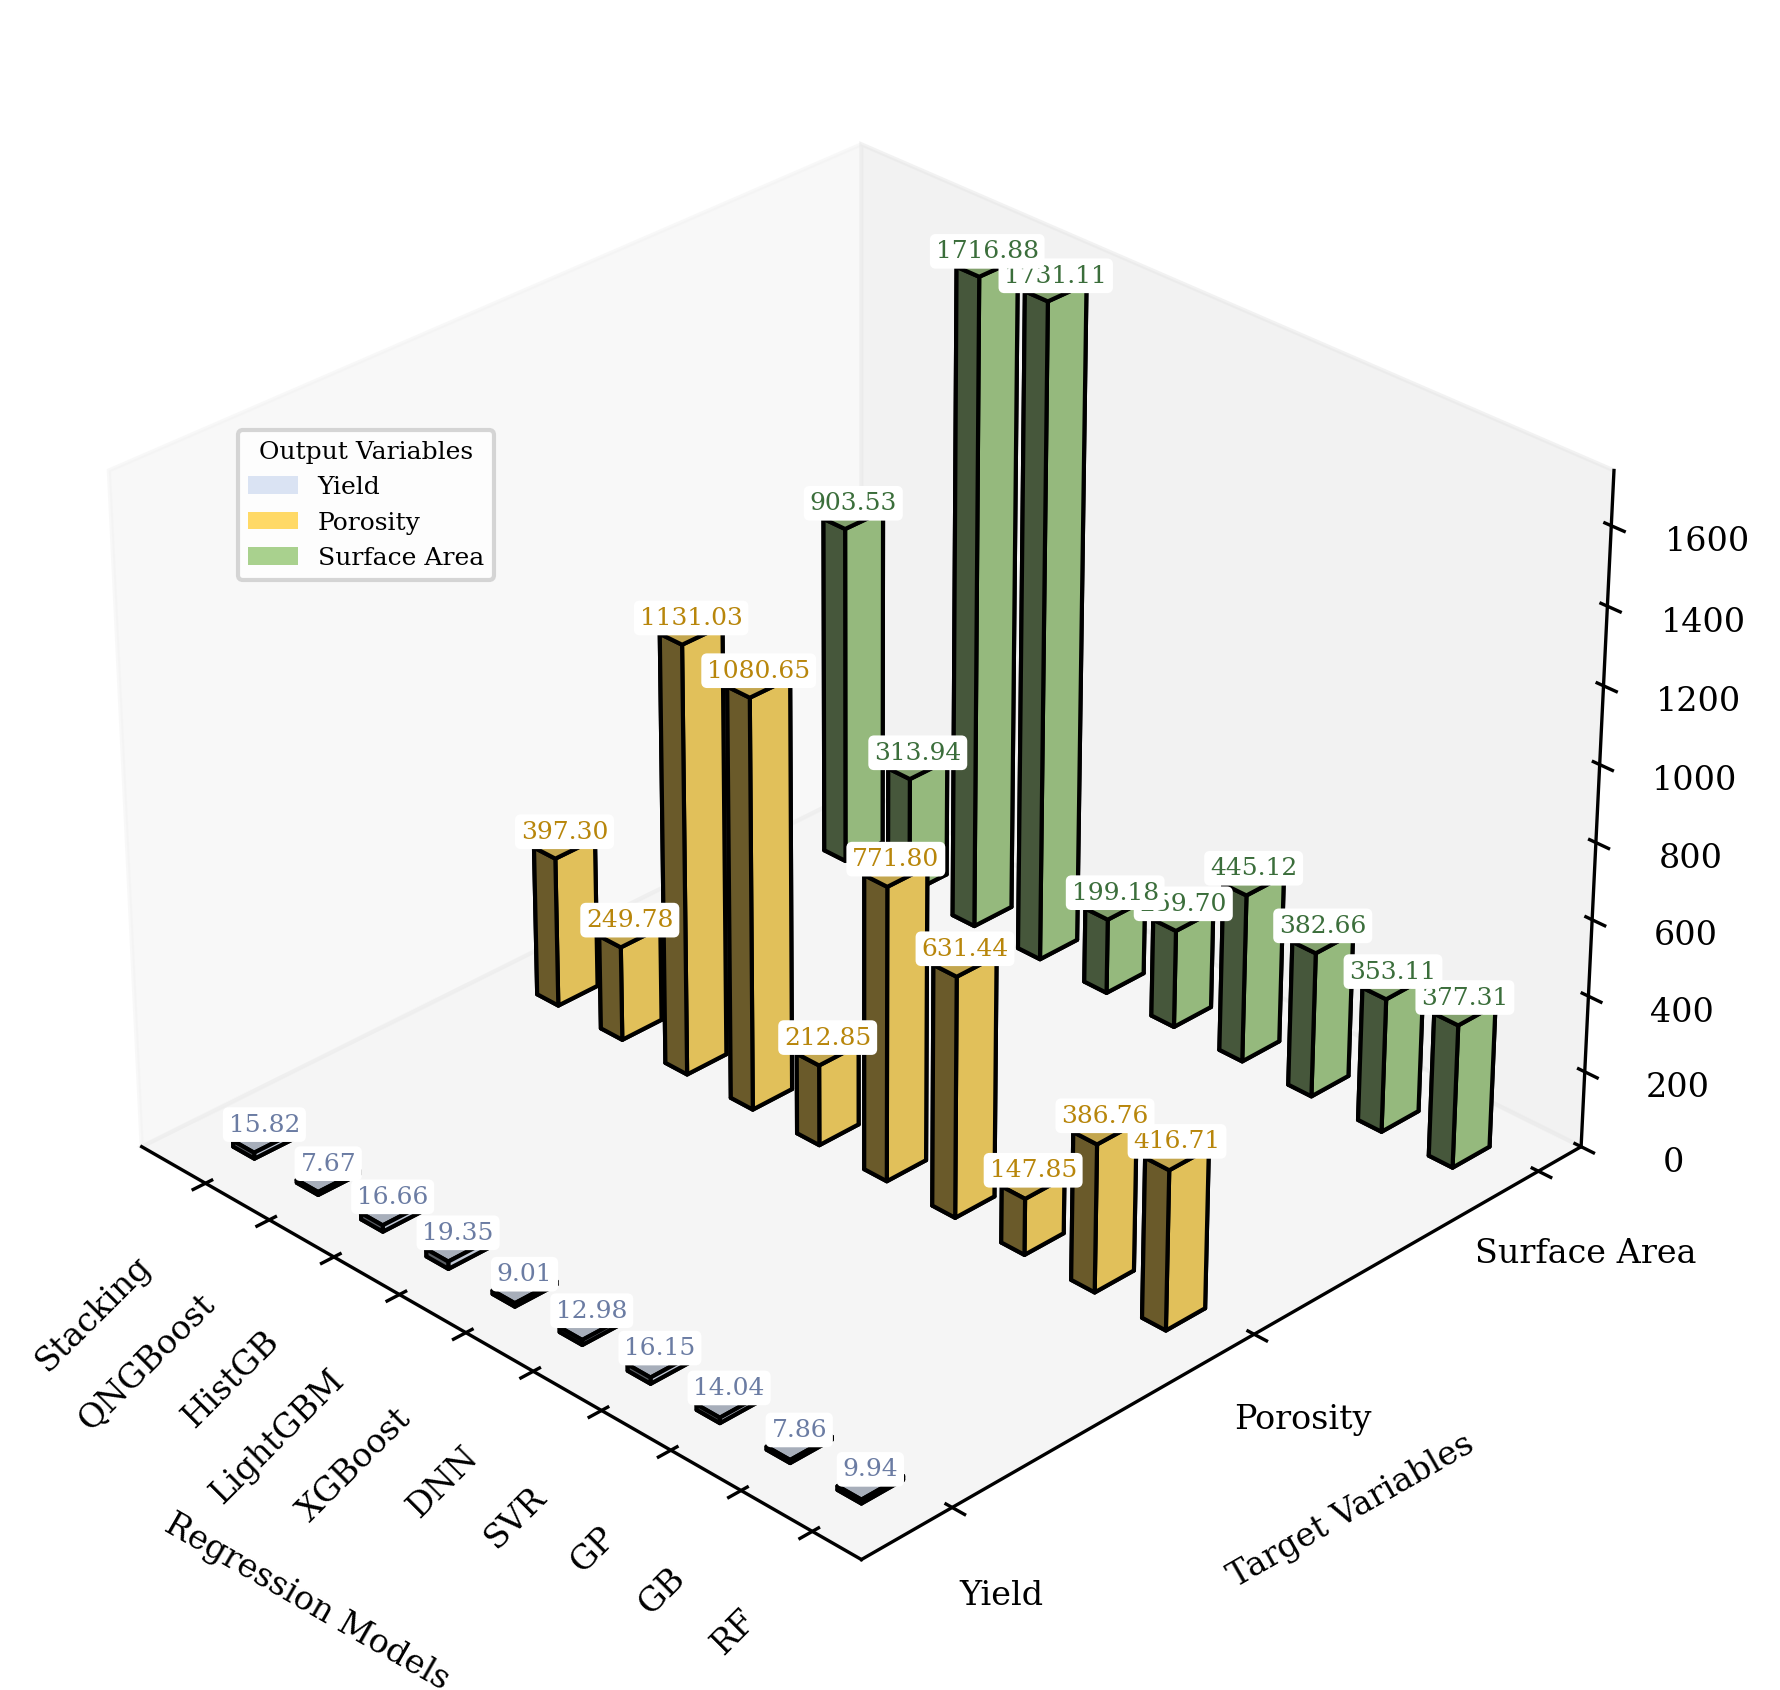

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rcParams
from matplotlib.patches import Patch

# Font setup: Nature-style
rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize":8,
    "figure.dpi": 300
})

# Desired output stacking order: Surface Area → Porosity → Yield
outputs = ['Surface Area', 'Porosity', 'Yield']
models = [
    'RandomForest', 'GradientBoosting', 'GaussianProcess', 'SVR', 'DNN',
    'XGBoost', 'LightGBM', 'HistGB', 'QuantileNGBoost', 'Stacking'
]

# Fill colors
colors = {
    'Yield': '#DAE3F3',
    'Surface Area': '#A9D18E',
    'Porosity': '#FFD966'
}

# Text colors
text_colors = {
    'Yield': '#6B7CA3',
    'Surface Area': '#3B6E3B',
    'Porosity': '#B8860B'
}
label_map = {
    'RandomForest': 'RF',
    'GradientBoosting': 'GB',
    'GaussianProcess': 'GP',
    'SVR': 'SVR',
    'DNN': 'DNN',
    'XGBoost': 'XGBoost',
    'LightGBM': 'LightGBM',
    'HistGB': 'HistGB',
    'QuantileNGBoost': 'QNGBoost',
    'Stacking': 'Stacking'
}
# Prepare MAPE matrix
z_values = np.array([
    all_results[model][output]['MAPE']
    for output in outputs
    for model in models
])

# Updated Y positions: Surface Area (bottom), Porosity, Yield (top)
_y = np.array([0, 6, 12])
_x = np.arange(len(models)) * 3
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
dz = z_values
dx = 1
dy = 0.8
z = np.zeros_like(dz)

# Bar & annotation assignments
bar_colors = [colors[outputs[j]] for j in np.repeat(np.arange(len(outputs)), len(models))]
text_labels = np.repeat(outputs, len(models))

# Plot
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, dx, dy, dz, color=bar_colors, edgecolor='black', shade=True)

# Axes
ax.set_xlabel("Regression Models", labelpad=27)
ax.set_ylabel("Target Variables", labelpad=10)
ax.set_zlabel("MAPE (%)", labelpad=12)
ax.set_zlim(0, np.nanmax(dz) + 5)

ax.set_xticks(_x)
ax.set_xticklabels([label_map[m] for m in model_names], rotation=45, ha='right', fontsize=8)
ax.set_yticks(_y)
ax.set_yticklabels(outputs, fontsize=8)
ax.tick_params(axis='both', which='major', pad=5)

# Annotations
for i in range(len(dz)):
    output_type = text_labels[i]
    ax.text(
        x[i] + dx / 2, y[i] + dy / 2, dz[i] + 0.5,
        f"{dz[i]:.2f}",
        ha='center', va='bottom',
        fontsize=6,
        color=text_colors[output_type],
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.15')
    )

# View and legend
ax.view_init(elev=30, azim=135)
ax.grid(False)

legend_elements = [Patch(facecolor=colors[o], label=o) for o in outputs[::-1]]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.12, 0.76),
          title='Output Variables', fontsize=6, title_fontsize=6)

# Save and show
plt.tight_layout()
plt.savefig("mape_3d_model_comparison.png", dpi=300, bbox_inches='tight')
plt.savefig("mape_3d_model_comparison.pdf", bbox_inches='tight')
plt.show()


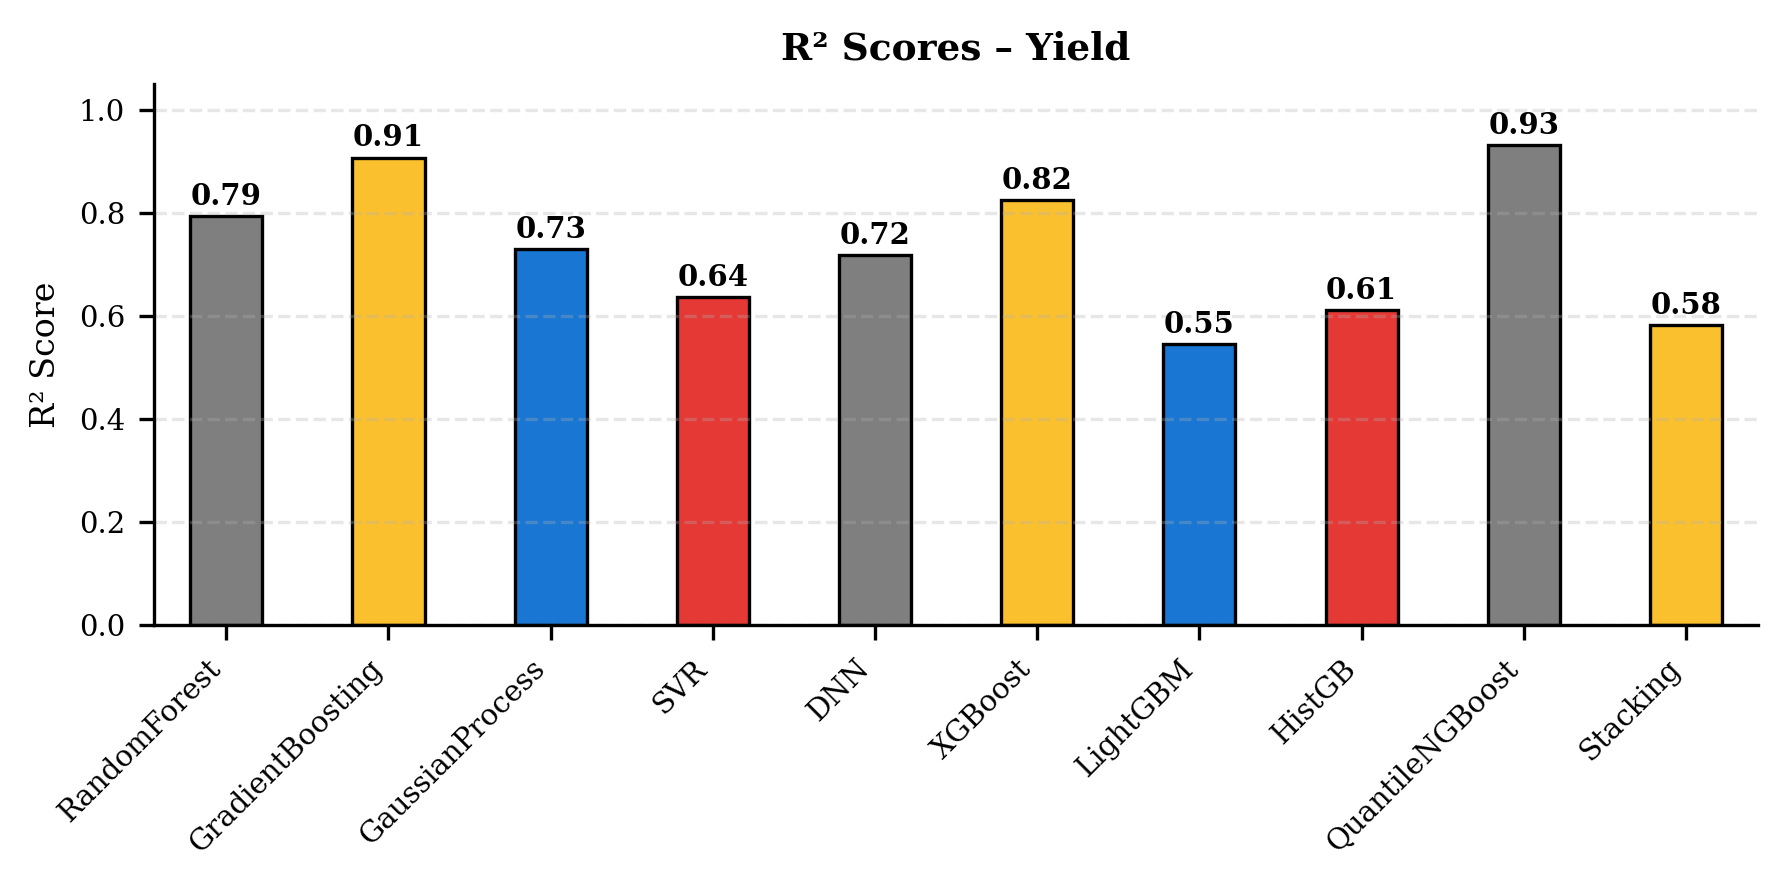

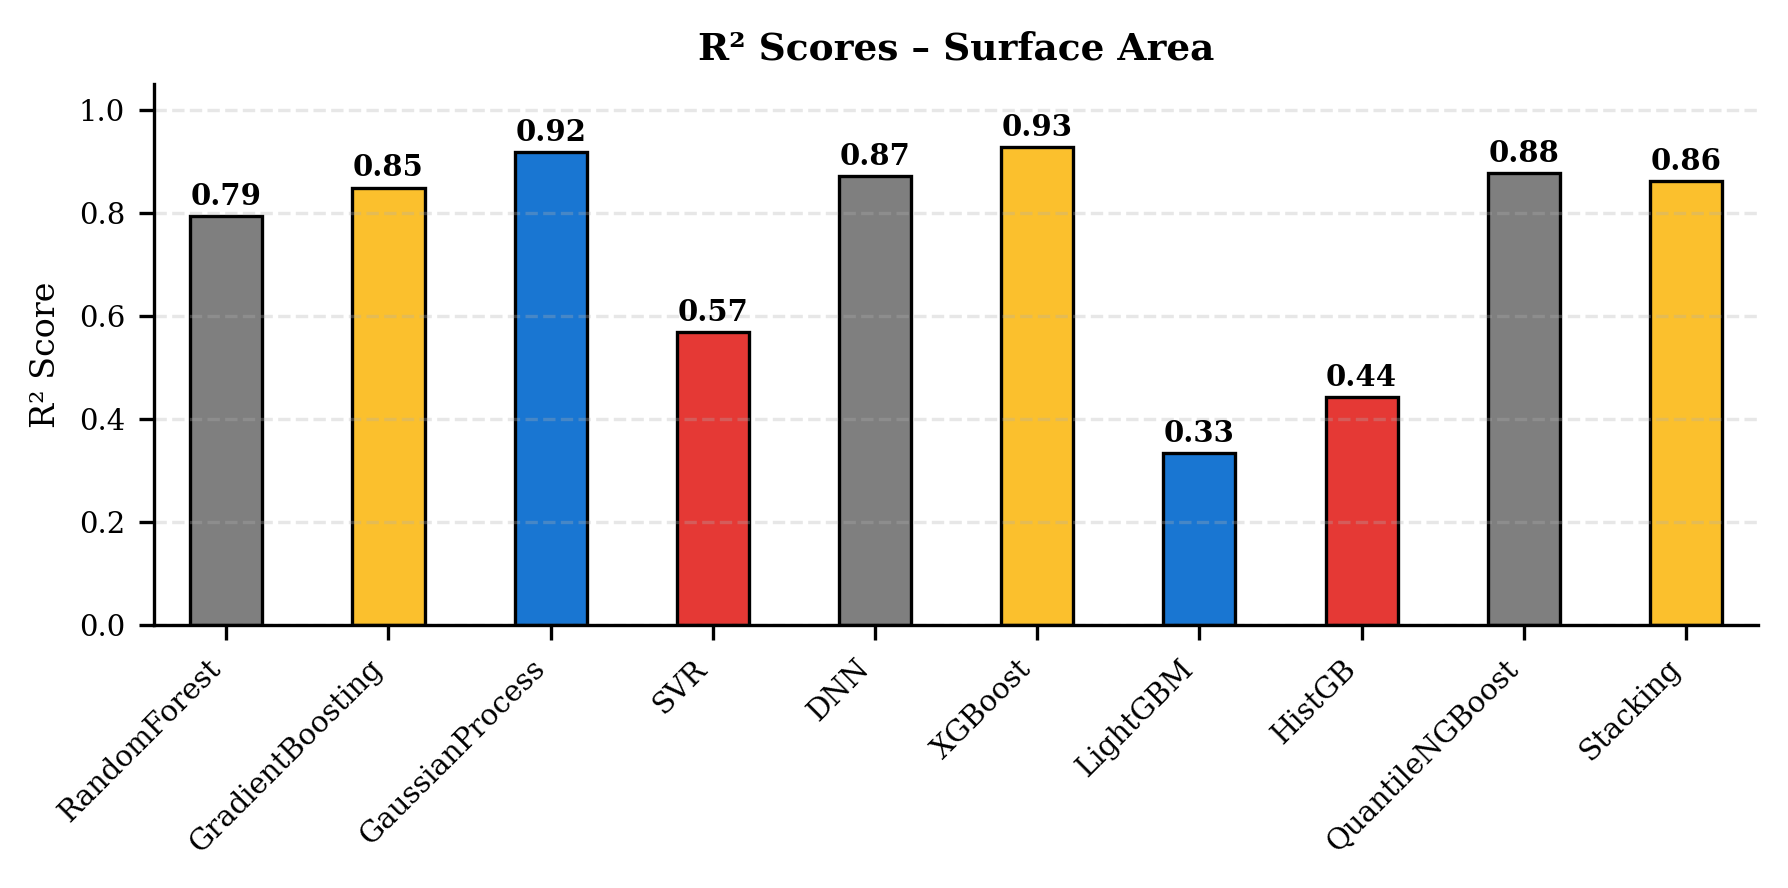

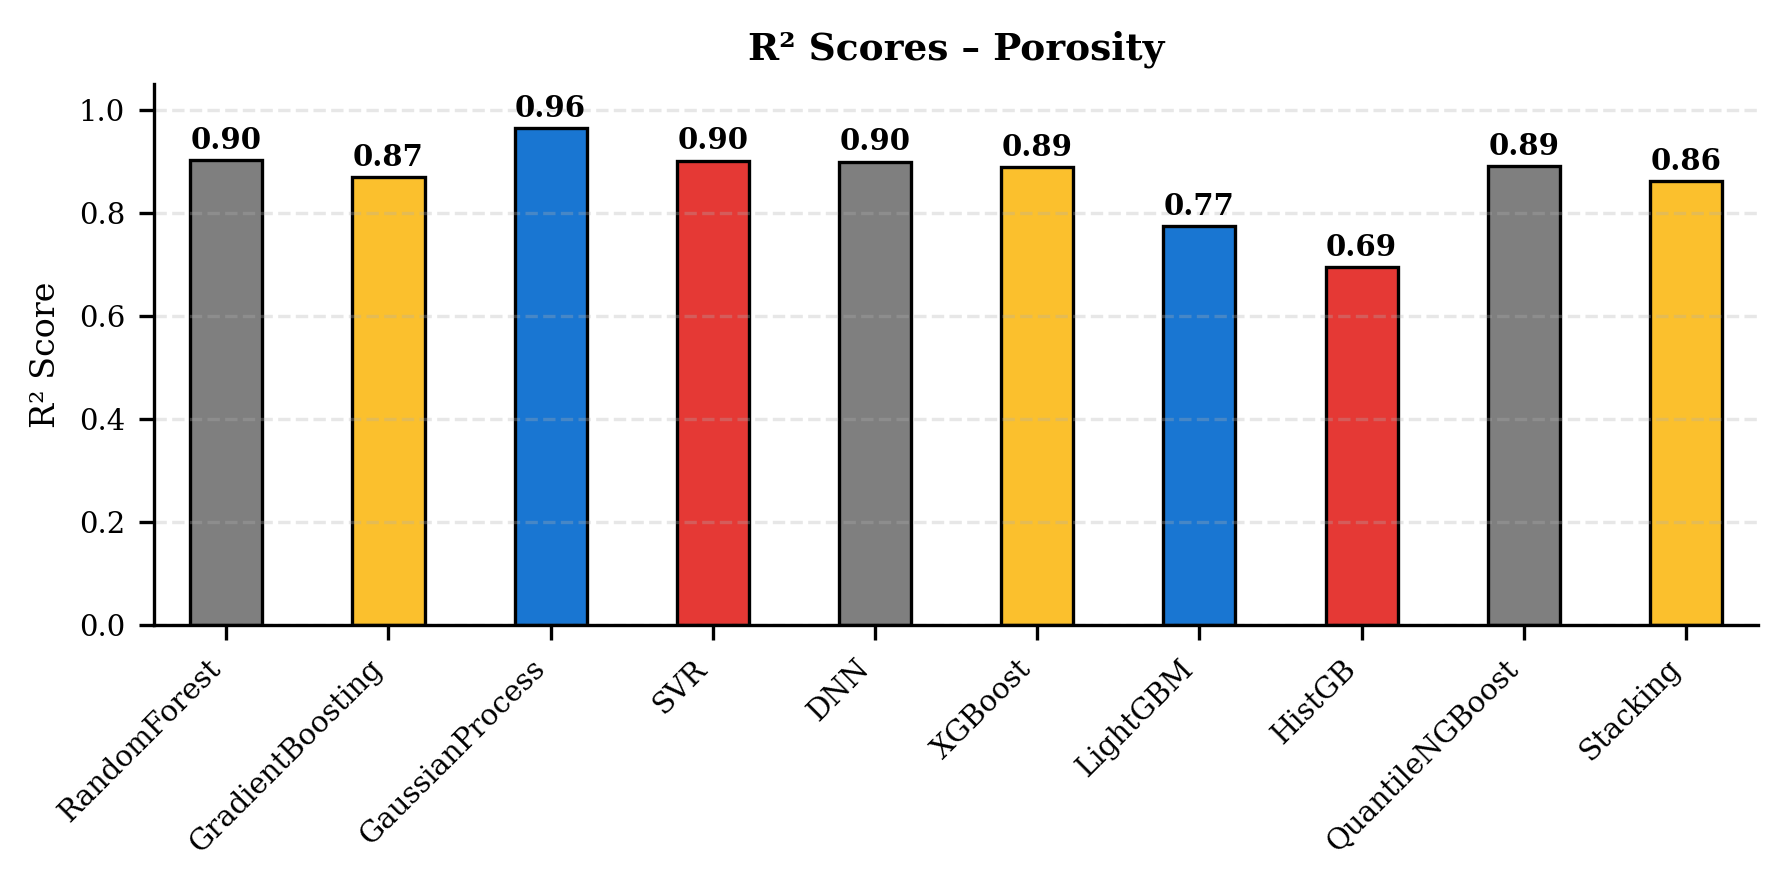

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# R² values
all_results = {
    'RandomForest': {'Yield': {'R2': 0.7942}, 'Surface Area': {'R2': 0.7941}, 'Porosity': {'R2': 0.9019}},
    'GradientBoosting': {'Yield': {'R2': 0.9073}, 'Surface Area': {'R2': 0.8492}, 'Porosity': {'R2': 0.8699}},
    'GaussianProcess': {'Yield': {'R2': 0.7298}, 'Surface Area': {'R2': 0.9187}, 'Porosity': {'R2': 0.9639}},
    'SVR': {'Yield': {'R2': 0.6374}, 'Surface Area': {'R2': 0.5682}, 'Porosity': {'R2': 0.9016}},
    'DNN': {'Yield': {'R2': 0.7181}, 'Surface Area': {'R2': 0.8717}, 'Porosity': {'R2': 0.8994}},
    'XGBoost': {'Yield': {'R2': 0.8242}, 'Surface Area': {'R2': 0.9282}, 'Porosity': {'R2': 0.8881}},
    'LightGBM': {'Yield': {'R2': 0.5454}, 'Surface Area': {'R2': 0.3336}, 'Porosity': {'R2': 0.7738}},
    'HistGB': {'Yield': {'R2': 0.6112}, 'Surface Area': {'R2': 0.4423}, 'Porosity': {'R2': 0.6945}},
    'QuantileNGBoost': {'Yield': {'R2': 0.9318}, 'Surface Area': {'R2': 0.8767}, 'Porosity': {'R2': 0.8910}},
    'Stacking': {'Yield': {'R2': 0.5818}, 'Surface Area': {'R2': 0.8625}, 'Porosity': {'R2': 0.8612}}
}

models = list(all_results.keys())
outputs = ['Yield', 'Surface Area', 'Porosity']

# 4-color pattern repeated
color_cycle = ['#7f7f7f', '#fbc02d', '#1976d2', '#e53935']
bar_width = 0.2  # thinner bars
spacing = 0.25   # less spacing between bars

for output in outputs:
    values = [all_results[model][output]['R2'] for model in models]
    x = np.arange(len(models)) * (bar_width + spacing)

    fig, ax = plt.subplots(figsize=(6, 3))  # smaller figure
    ax.set_facecolor('white')

    for i, val in enumerate(values):
        color = color_cycle[i % len(color_cycle)]
        x_val = x[i]

        # Thin rectangle bar
        rect = patches.Rectangle(
            (x_val, 0), bar_width, val,
            facecolor=color, edgecolor='black', linewidth=0.8
        )
        ax.add_patch(rect)

        # Label on top
        ax.text(x_val + bar_width / 2, val + 0.01, f"{val:.2f}",
                ha='center', va='bottom', fontsize=7, fontweight='bold')

    # Axes formatting
    ax.set_xlim(-0.1, x[-1] + bar_width + 0.1)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel("R² Score", fontsize=8)
    ax.set_title(f"R² Scores – {output}", fontsize=9, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='y', labelsize=7)

    plt.tight_layout()
    plt.savefig(f"R2_{output.replace(' ', '_')}_compact.png", dpi=300, bbox_inches='tight')
    plt.show()


<ipython-input-15-e41d2c5b97a6>:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


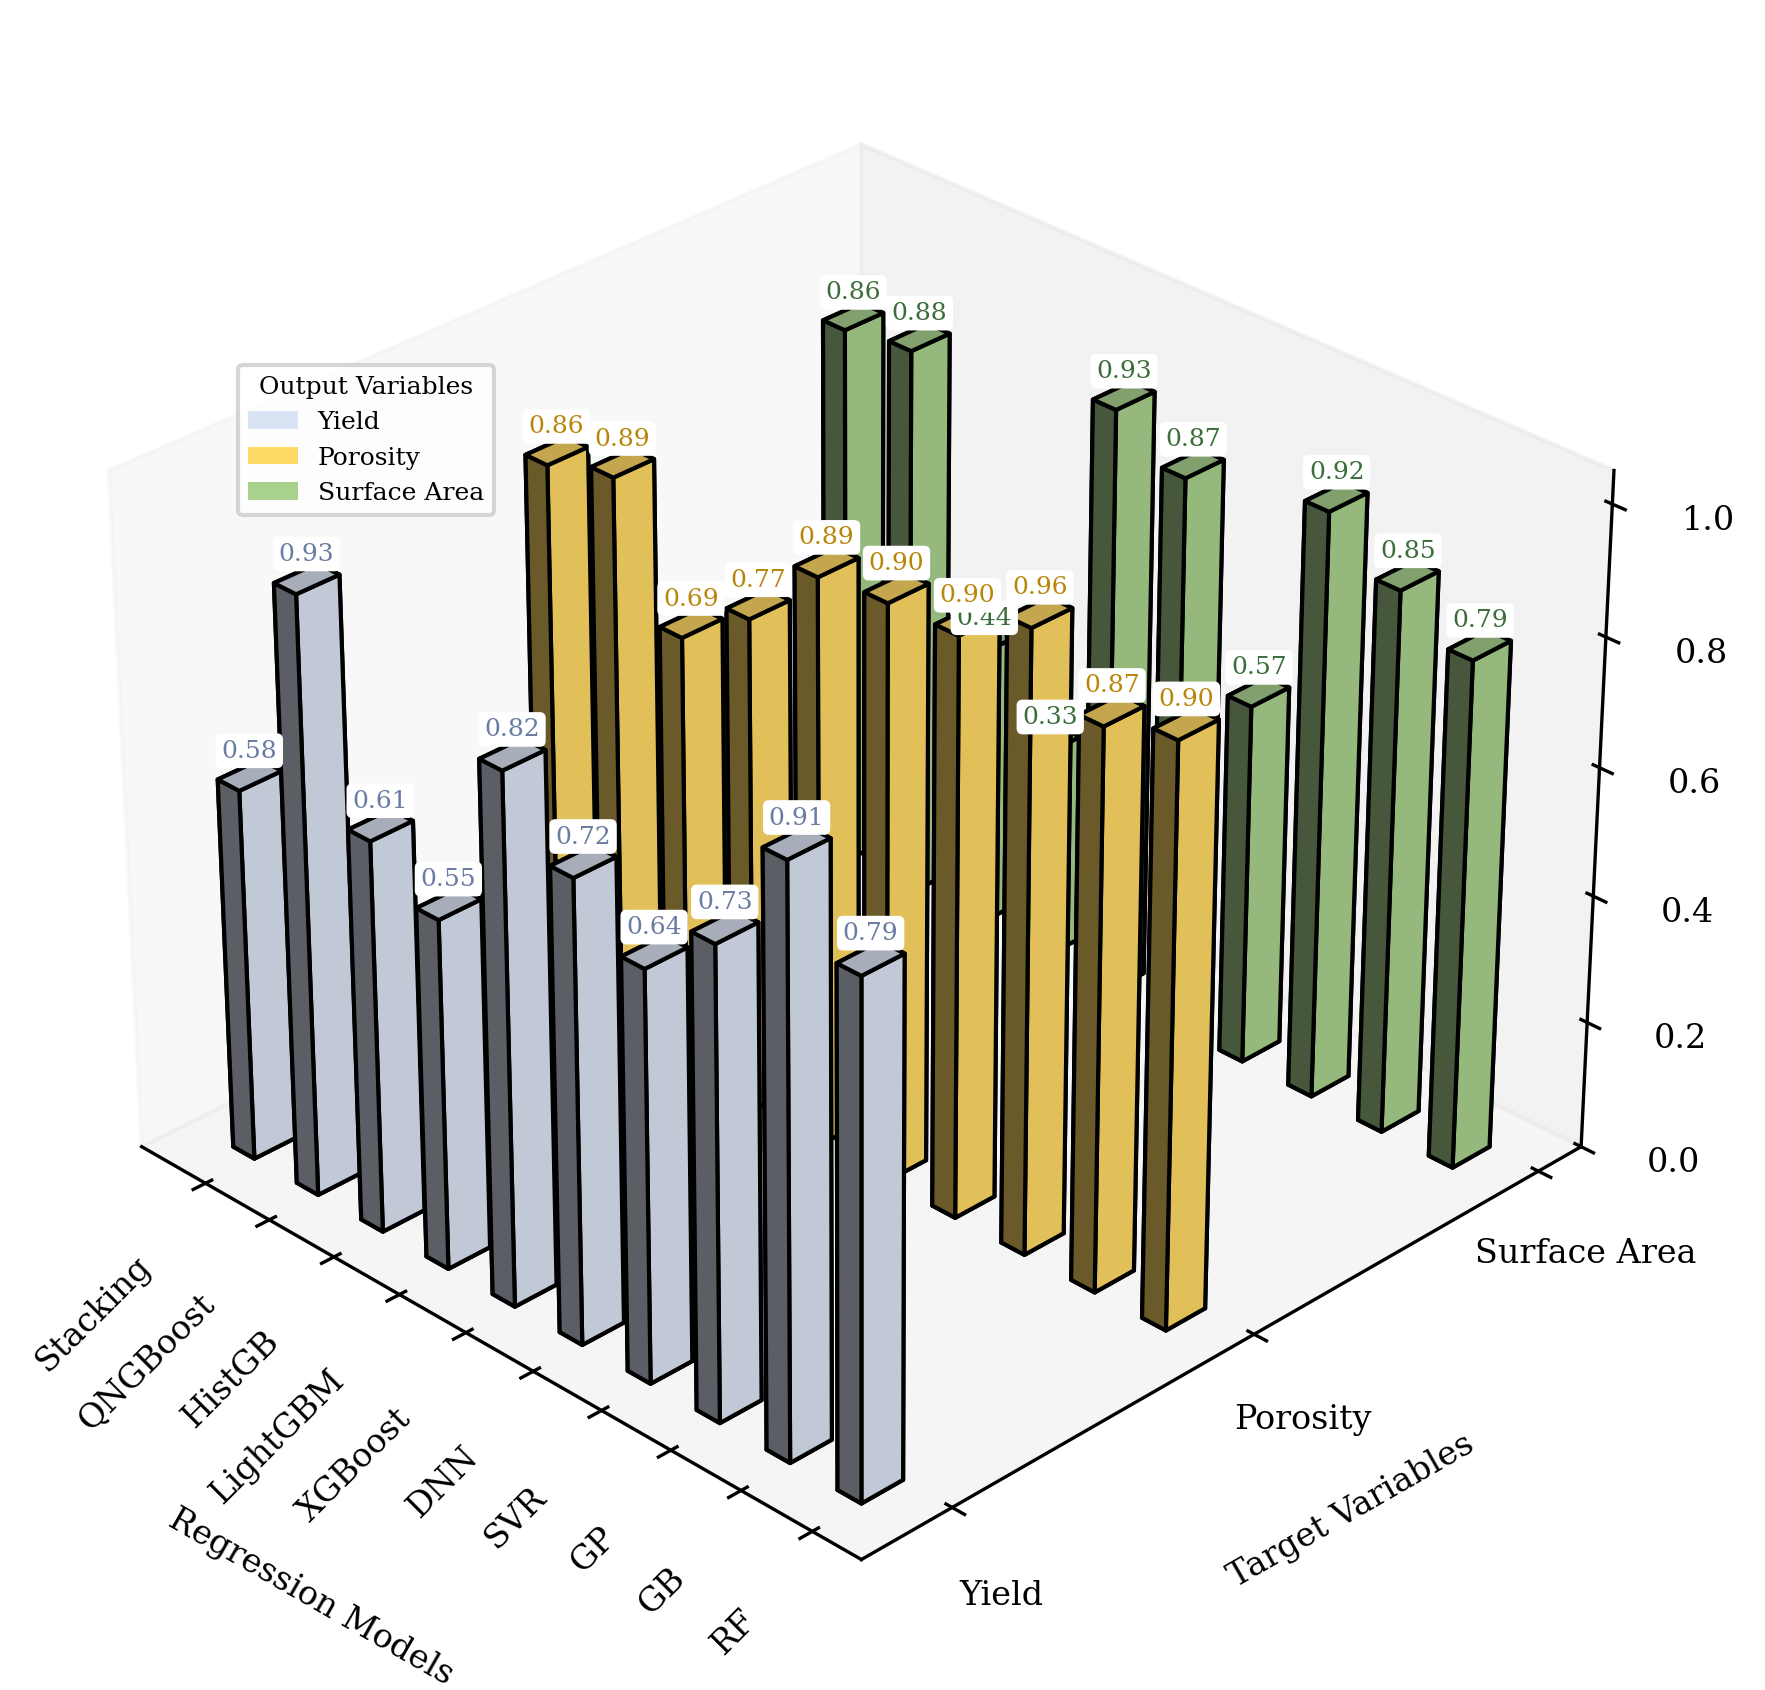

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import rcParams
from matplotlib.patches import Patch

# Font setup: Nature-style
rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300
})

# R² values
all_results = {
    'RandomForest': {'Yield': 0.7942, 'Surface Area': 0.7941, 'Porosity': 0.9019},
    'GradientBoosting': {'Yield': 0.9073, 'Surface Area': 0.8492, 'Porosity': 0.8699},
    'GaussianProcess': {'Yield': 0.7298, 'Surface Area': 0.9187, 'Porosity': 0.9639},
    'SVR': {'Yield': 0.6374, 'Surface Area': 0.5682, 'Porosity': 0.9016},
    'DNN': {'Yield': 0.7181, 'Surface Area': 0.8717, 'Porosity': 0.8994},
    'XGBoost': {'Yield': 0.8242, 'Surface Area': 0.9282, 'Porosity': 0.8881},
    'LightGBM': {'Yield': 0.5454, 'Surface Area': 0.3336, 'Porosity': 0.7738},
    'HistGB': {'Yield': 0.6112, 'Surface Area': 0.4423, 'Porosity': 0.6945},
    'QuantileNGBoost': {'Yield': 0.9318, 'Surface Area': 0.8767, 'Porosity': 0.8910},
    'Stacking': {'Yield': 0.5818, 'Surface Area': 0.8625, 'Porosity': 0.8612}
}

models = list(all_results.keys())

# Desired output stacking order: Surface Area (bottom), Porosity (middle), Yield (top)
targets = ['Surface Area', 'Porosity', 'Yield']

# Bar fill colors
colors = {
    'Yield': '#DAE3F3',
    'Surface Area': '#A9D18E',
    'Porosity': '#FFD966'
}

# Text annotation colors
text_colors = {
    'Yield': '#6B7CA3',
    'Surface Area': '#3B6E3B',
    'Porosity': '#B8860B'
}
label_map = {
    'RandomForest': 'RF',
    'GradientBoosting': 'GB',
    'GaussianProcess': 'GP',
    'SVR': 'SVR',
    'DNN': 'DNN',
    'XGBoost': 'XGBoost',
    'LightGBM': 'LightGBM',
    'HistGB': 'HistGB',
    'QuantileNGBoost': 'QNGBoost',
    'Stacking': 'Stacking'
}
# Updated Y positions
_y = np.array([0, 6, 12])  # Surface → Porosity → Yield
_x = np.arange(len(models)) * 3
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

# Flattened R² values
z = np.array([
    all_results[models[i]][targets[j]]
    for j in range(len(targets))
    for i in range(len(models))
])
dz = z
dx = 1
dy = 0.8
z = np.zeros_like(dz)

# Colors for bars and annotations
bar_colors = [colors[targets[j]] for j in np.repeat(np.arange(len(targets)), len(models))]
bar_labels = np.repeat(targets, len(models))

# Plotting
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x, y, z, dx, dy, dz, color=bar_colors, edgecolor='black', shade=True)

# Axes labels
ax.set_xlabel("Regression Models", labelpad=26)
ax.set_ylabel("Target Variables", labelpad=10)
ax.set_zlabel("R² Score", labelpad=12)
ax.set_zlim(0, 1.05)

ax.set_xticks(_x)
ax.set_xticklabels([label_map[m] for m in model_names], rotation=45, ha='right', fontsize=8)
ax.set_yticks(_y)
ax.set_yticklabels(targets, fontsize=8)
ax.tick_params(axis='both', which='major', pad=5)

# Annotate each bar
for i in range(len(dz)):
    label = bar_labels[i]
    ax.text(
        x[i] + dx / 2, y[i] + dy / 2, dz[i] + 0.02,
        f"{dz[i]:.2f}",
        ha='center', va='bottom',
        fontsize=6,
        color=text_colors[label],
        bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.15')
    )

# View and legend
ax.view_init(elev=30, azim=135)
ax.grid(False)

# Legend in correct top-down stacking order
legend_elements = [Patch(facecolor=colors[t], label=t) for t in targets[::-1]]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.12, 0.8),
          title='Output Variables', fontsize=6, title_fontsize=6)

# Save
plt.tight_layout()
plt.savefig("r2_3d_model_comparison_fixed_xticks.png", dpi=300, bbox_inches='tight')
plt.savefig("r2_3d_model_comparison_fixed_xticks.pdf", bbox_inches='tight')
plt.show()


**Predicted vs. Actual Scatter Plots**


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


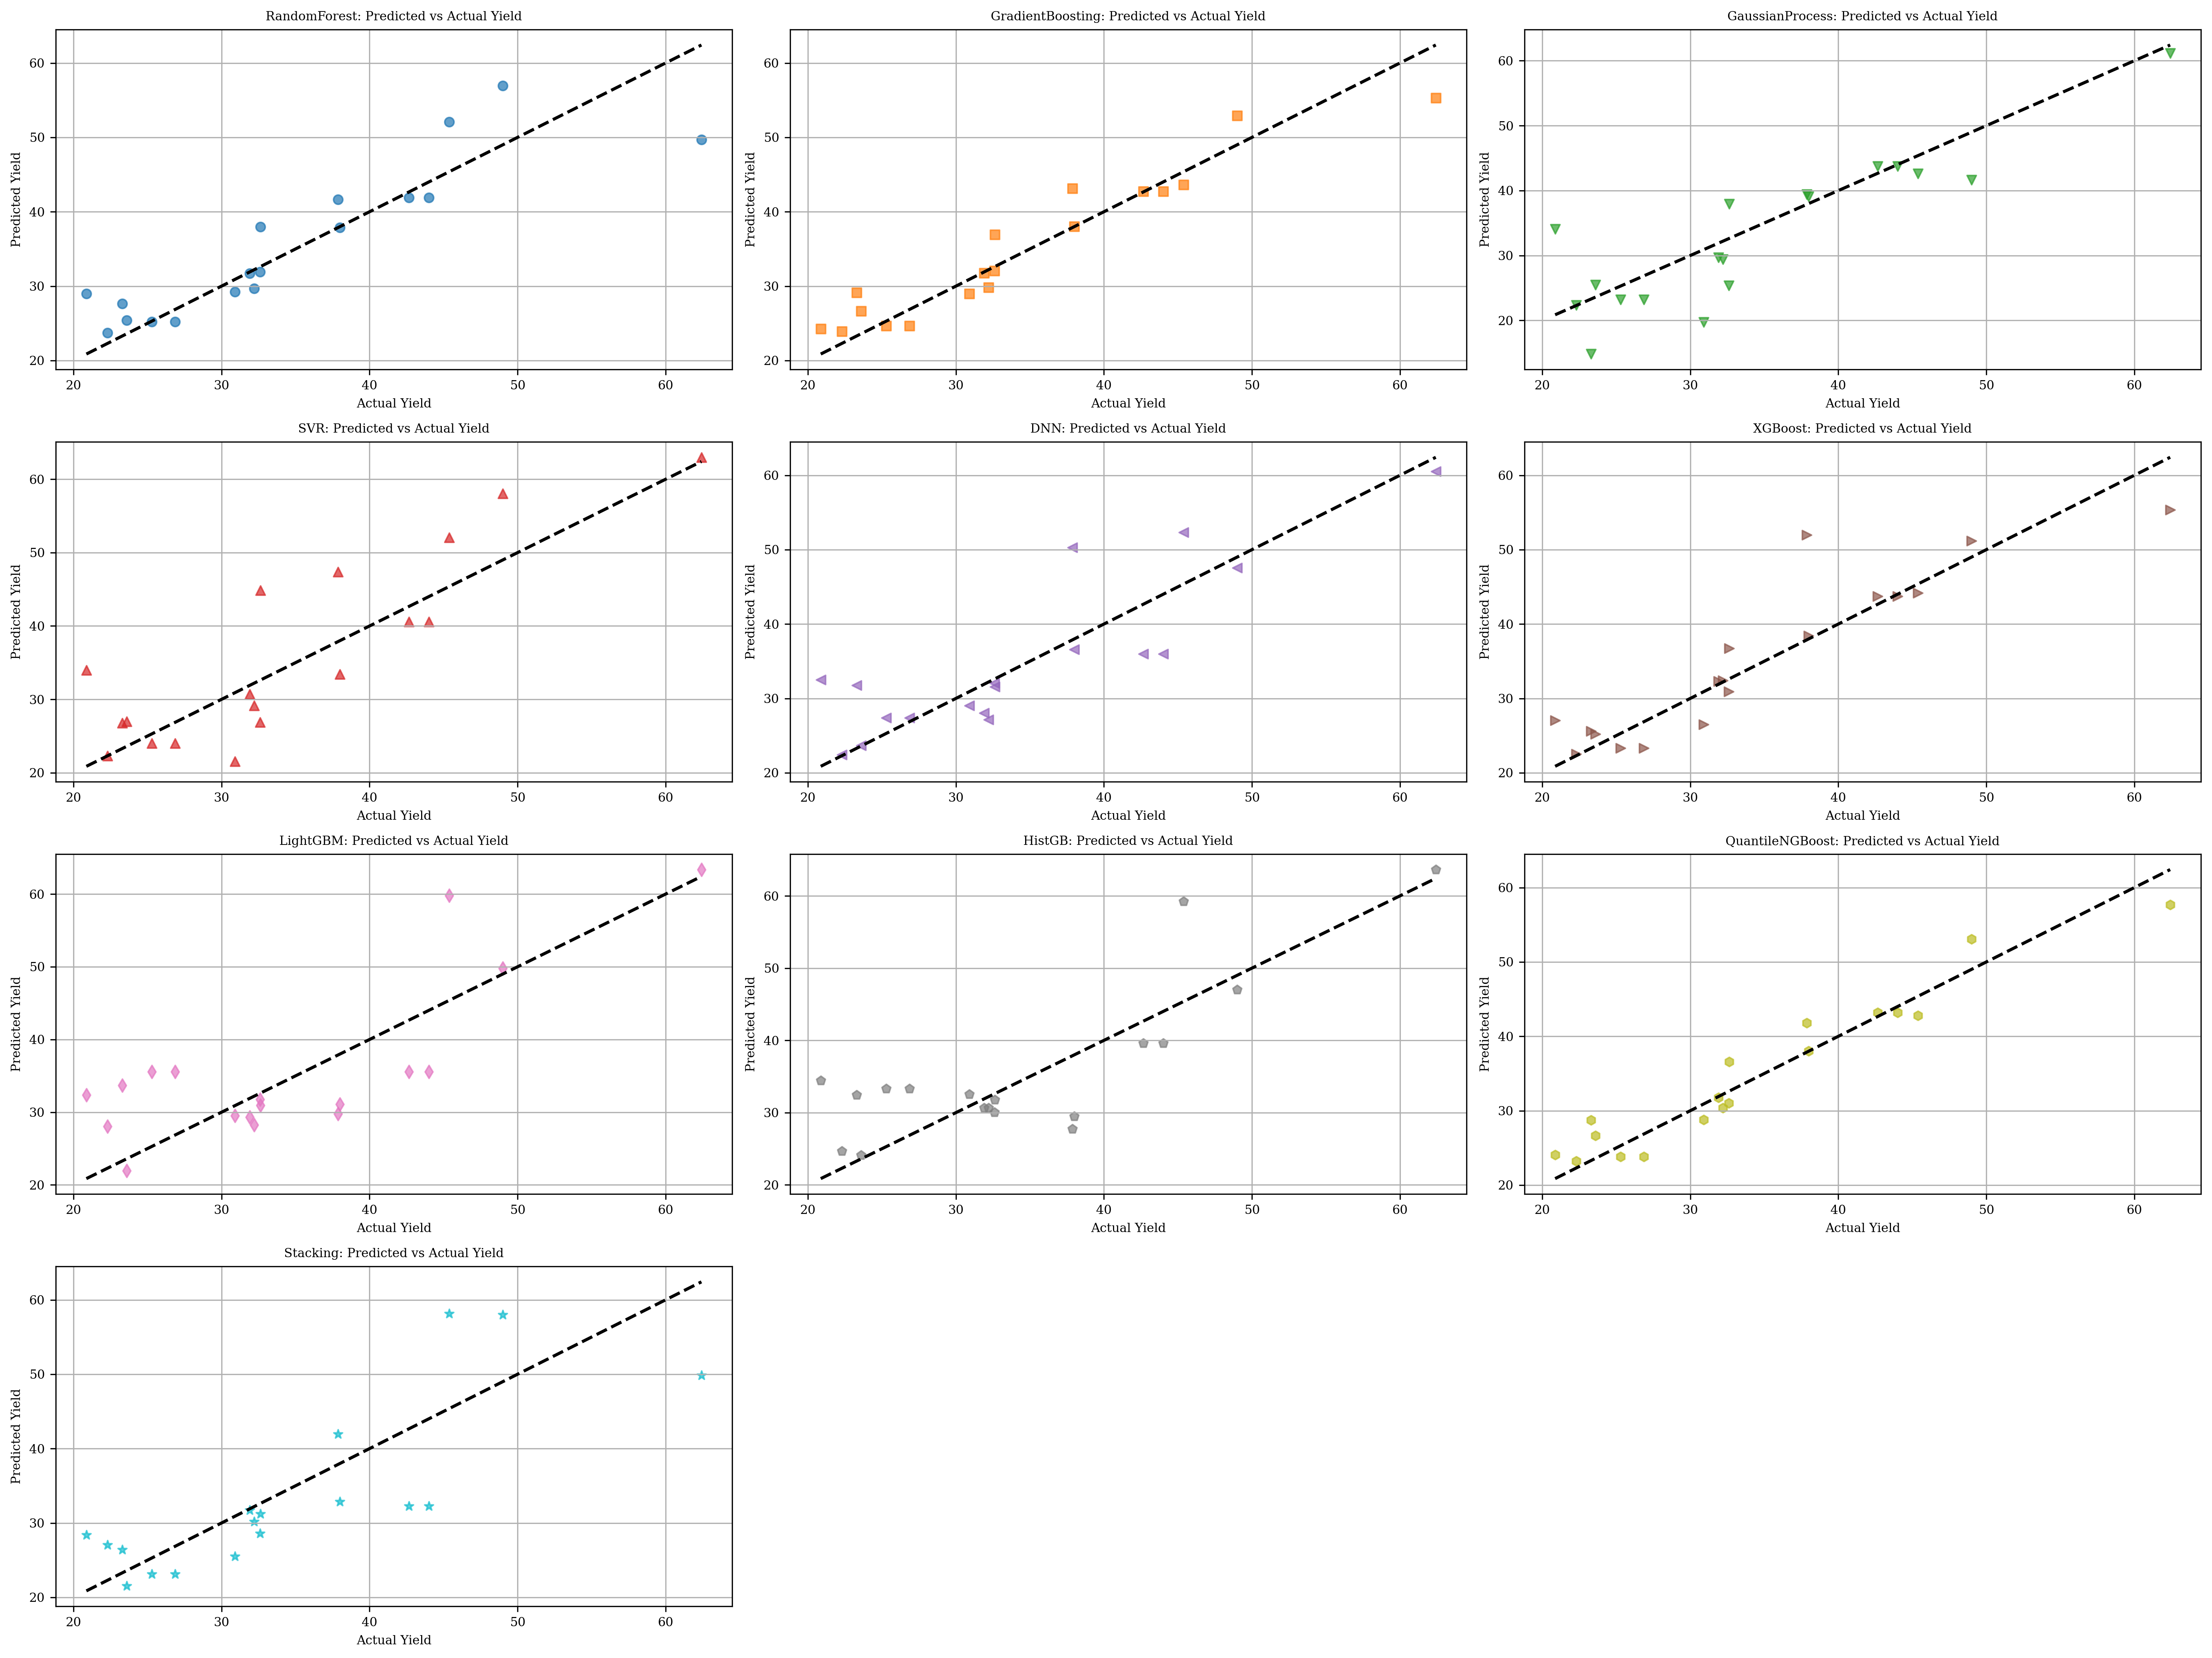

In [16]:
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Define model names and corresponding file paths
model_names = [
    'RandomForest', 'GradientBoosting', 'GaussianProcess', 'SVR', 'DNN',
    'XGBoost', 'LightGBM', 'HistGB', 'QuantileNGBoost', 'Stacking'
]

# Colors and markers for better visuals
colors = plt.cm.tab10.colors
markers = ['o', 's', 'v', '^', '<', '>', 'd', 'p', 'h', '*']

plt.figure(figsize=(20, 15))

for idx, model_name in enumerate(model_names):
    try:
        model = joblib.load(f'model_{model_name}.pkl')
        y_pred = model.predict(X_test)
        y_actual = Y_test[:, 0]  # Yield is assumed to be the first column
        y_pred_yield = y_pred[:, 0]

        plt.subplot(4, 3, idx+1)
        plt.scatter(y_actual, y_pred_yield, color=colors[idx % 10], marker=markers[idx % 10], alpha=0.7)
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
        plt.xlabel("Actual Yield")
        plt.ylabel("Predicted Yield")
        plt.title(f"{model_name}: Predicted vs Actual Yield")
        plt.grid(True)

    except Exception as e:
        print(f"Could not plot for {model_name}: {e}")

plt.tight_layout()
#plt.suptitle("Predicted vs. Actual Yield for All Models", fontsize=20, y=1.02)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


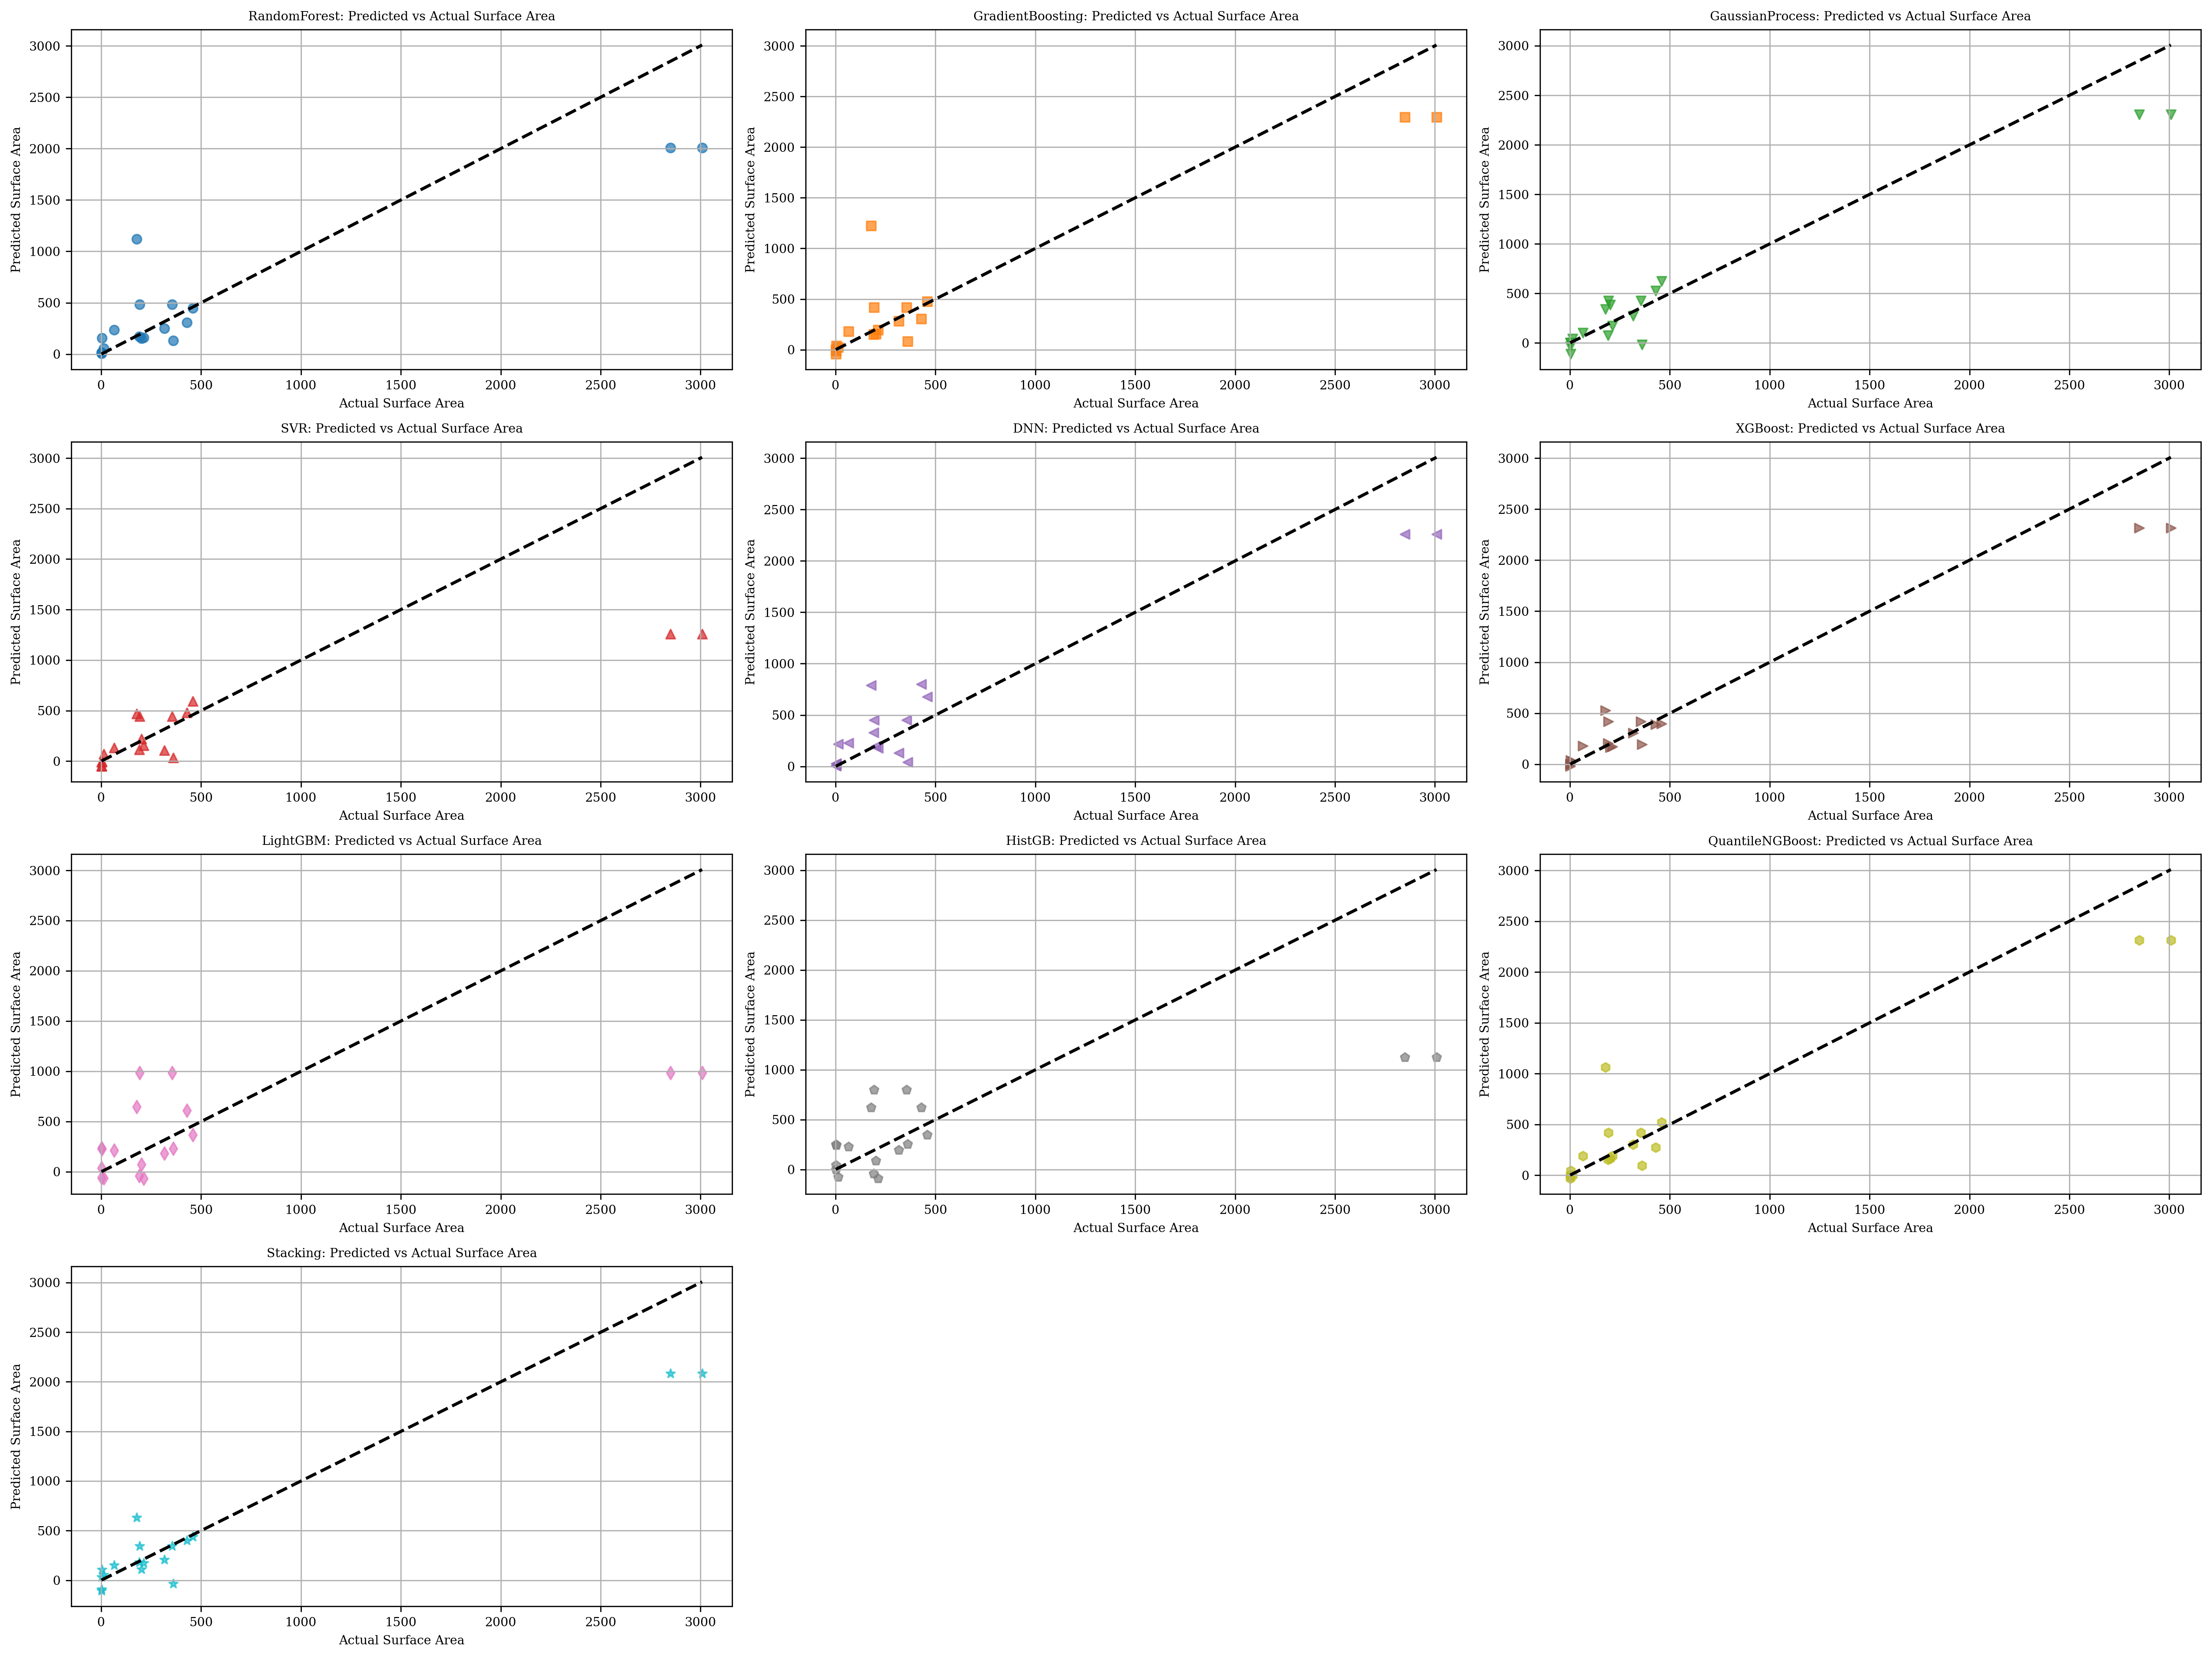

In [17]:
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Define model names and corresponding file paths
model_names = [
    'RandomForest', 'GradientBoosting', 'GaussianProcess', 'SVR', 'DNN',
    'XGBoost', 'LightGBM', 'HistGB', 'QuantileNGBoost', 'Stacking'
]

# Colors and markers for better visuals
colors = plt.cm.tab10.colors
markers = ['o', 's', 'v', '^', '<', '>', 'd', 'p', 'h', '*']

plt.figure(figsize=(20, 15))

for idx, model_name in enumerate(model_names):
    try:
        model = joblib.load(f'model_{model_name}.pkl')
        y_pred = model.predict(X_test)
        y_actual = Y_test[:, 1]  # Surface Area is the second column
        y_pred_surface = y_pred[:, 1]

        plt.subplot(4, 3, idx+1)
        plt.scatter(y_actual, y_pred_surface, color=colors[idx % 10], marker=markers[idx % 10], alpha=0.7)
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
        plt.xlabel("Actual Surface Area")
        plt.ylabel("Predicted Surface Area")
        plt.title(f"{model_name}: Predicted vs Actual Surface Area")
        plt.grid(True)

    except Exception as e:
        print(f"Could not plot for {model_name}: {e}")

plt.tight_layout()
#plt.suptitle("Predicted vs. Actual Surface Area for All Models", fontsize=20, y=1.02)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


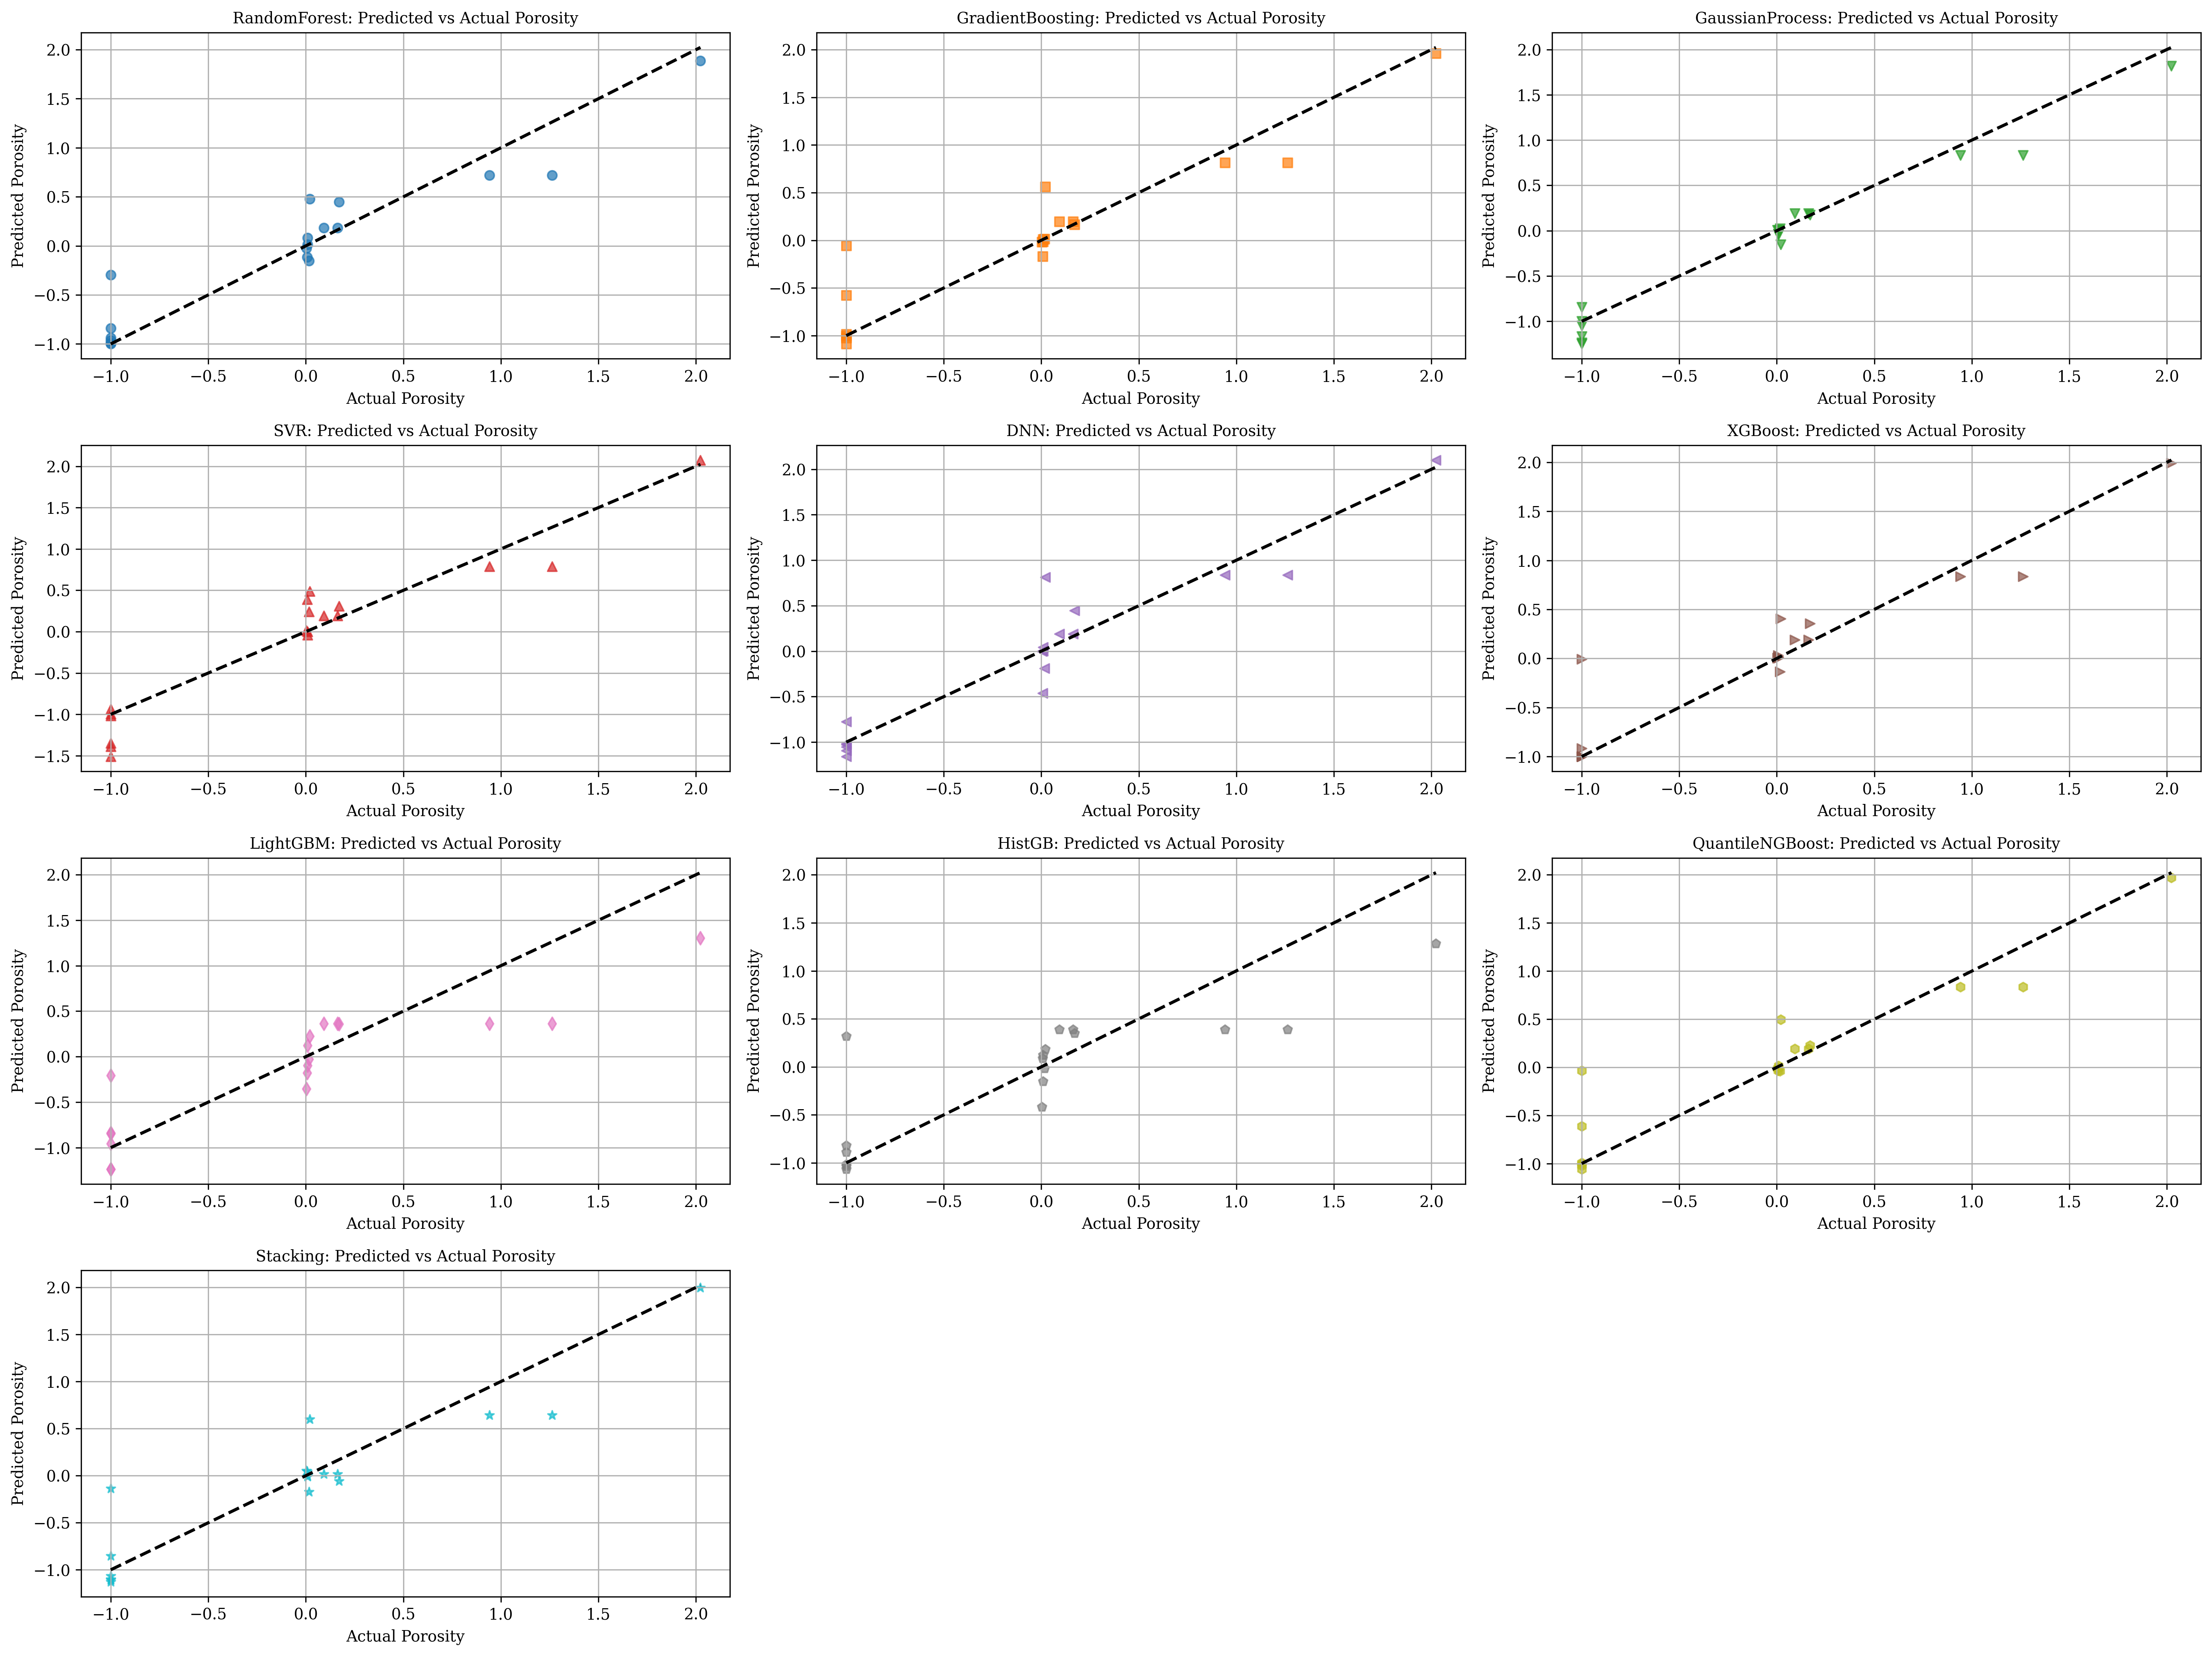

In [ ]:
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Define model names and corresponding file paths
model_names = [
    'RandomForest', 'GradientBoosting', 'GaussianProcess', 'SVR', 'DNN',
    'XGBoost', 'LightGBM', 'HistGB', 'QuantileNGBoost', 'Stacking'
]

# Colors and markers for better visuals
colors = plt.cm.tab10.colors
markers = ['o', 's', 'v', '^', '<', '>', 'd', 'p', 'h', '*']

plt.figure(figsize=(20, 15))

for idx, model_name in enumerate(model_names):
    try:
        model = joblib.load(f'model_{model_name}.pkl')
        y_pred = model.predict(X_test)
        y_actual = Y_test[:, 2]  # Porosity is the third column
        y_pred_porosity = y_pred[:, 2]

        plt.subplot(4, 3, idx+1)
        plt.scatter(y_actual, y_pred_porosity, color=colors[idx % 10], marker=markers[idx % 10], alpha=0.7)
        plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k--', lw=2)
        plt.xlabel("Actual Porosity")
        plt.ylabel("Predicted Porosity")
        plt.title(f"{model_name}: Predicted vs Actual Porosity")
        plt.grid(True)

    except Exception as e:
        print(f"Could not plot for {model_name}: {e}")

plt.tight_layout()
#plt.suptitle("Predicted vs. Actual Porosity for All Models", fontsize=20, y=1.02)
plt.show()
